# LSTM para previsão de casos do COVID-19

Aplicação da rede LSTM desenvolvida e disponibilizada por Luis Ricardo e Marcos Rodrigues.

O código foi organizado e aplicado como requisto para o trabalho de Matemática Computacional (CAP-239-4)

## Definição das funções do modelo


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# univariate data preparation
import numpy as np
from numpy import array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Flatten
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from numpy import array 
from numpy import hstack 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math, pickle, csv, os, warnings

path = os.getcwd() # Diretório atual

Using TensorFlow backend.


In [ ]:
def organizar_dados(path_input,tipo_analise,pais):
    path = os.path.join(path_input, tipo_analise)
    list_files_analise = os.listdir(path)
    list_files_analise.sort()
    serie_analise = pd.read_csv(os.path.join(path, list_files_analise[0]), 
                                  header = None, engine = 'python')
    select_analise = serie_analise[serie_analise[0] == pais]
    select_analise = select_analise[[0, 2, 3]]
    return select_analise


def split_sequences(sequences, n_steps_in, n_steps_out):
    '''
    Brownlee, J. (2018). Deep Learning for Time Series Forecasting: 
    Predict the Future with MLPs, CNNs and LSTMs in Python. 
    Machine Learning Mastery.
    '''
    X, y = list(), list() 
    for i in range(len(sequences)): 
        #find the end of this pattern 
        end_ix = i + n_steps_in 
        out_end_ix = end_ix + n_steps_out 
        #check if we are beyond the dataset 
        if out_end_ix > len(sequences): 
            break 
        #gather input and output parts of the pattern 
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix:out_end_ix] 
        X.append(seq_x) 
        y.append(seq_y) 
    return X, y

def preparar_dados(dados_covid, n_dias_entrada, n_dias_saida):    
    # choose a number of time steps 
    # covert into input/output
    dados_covid = dados_covid.iloc[:,2]
    dados_covid = np.float64(dados_covid.tolist())
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = dados_covid.reshape(-1, 1)
    data = scaler.fit_transform(data)
    data = data.reshape(len(data),)
    
    X, y = split_sequences(data, n_dias_entrada, n_dias_saida)
    
    inputarray = data[-n_dias_entrada:]
    inputarray = [float(i) for i in inputarray]
    inputarray = np.asarray(inputarray)

    X = np.float64(X)
    y = np.float64(y)    
    return data, X,y, inputarray,scaler


def definir_modelo_lstm_simples(modelo,n_dias_entrada, n_dias_saida):
    n_features = 1
    modelo.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_dias_entrada, n_features)))
    modelo.add(LSTM(200, activation='relu'))
    modelo.add(Dense(n_dias_saida))
    
    modelo.compile(optimizer='adam', loss='mse')
    return modelo

def treinamento(X,y,modelo,epocas,batch):
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # fit model
    history = modelo.fit(X, y, epochs=epocas,batch_size=batch)

    return history

def predict(modelo,inputarray,n_dias_entrada):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    return y_future

def validacao(modelo,n_dias_entrada,inputarray):
    n_features = 1
    x_input = inputarray
    x_input = x_input.reshape((1, n_dias_entrada, n_features))
    yhat = modelo.predict(x_input, verbose=0)
    
    y_future = np.asarray(yhat)
    y_future = yhat.ravel()
    y_future = np.float64(y_future)
    
    return y_future
   
def salvarmodelo(nome,modelo):
    #Salvando
    filename = nome+'.sav'
    pickle.dump(modelo, open(filename, 'wb'))
    

def salvardicionario(nome, history):
    #Salvando Dicionario
    w = csv.writer(open(nome+".csv", "w"))
    for key, val in history.items():
        w.writerow([key, val])    

def carregaModelo(nomeModelo):
    carrega_modelo = pickle.load(open(nomeModelo+'.sav', 'rb'))
    return carrega_modelo

**Função para treinamento automatizado**

In [ ]:
def gerarTreinamento_parametros(pais,version,n_entradas,n_saidas, epochs = 50, batch = 1):
    #Parametros: (path_input,tipo_analise,pais)
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    
    #Parametros: (dados_covid, n_dias_entrada, n_dias_saida) -- scaler - toback oringial data
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entradas, n_saidas)
    
    ##Parametros: (modelo,n_dias_entrada, n_dias_saida)
    modelo = Sequential()
    modelo = definir_modelo_lstm_simples(modelo,n_entradas, n_saidas)
    
    #Parametros: (X,y,modelo,epocas,batch)
    history = treinamento(X, y, modelo, epochs, batch)
    #cria dicionario
    history = history.history
    history.keys()
    
    #Salvando Dicionario
    salvardicionario("History_" + pais + "_" + version, history)
    salvarmodelo("Modelo_" + pais + "_" + version, modelo)

**Função para validação**

In [ ]:
def geraValidacao(pais, modelo, n_entrada, n_saida, plt_title = "RMSE: {rmse}"):
    daily_cases = organizar_dados(str(os.getcwd()), "Number_Daily_Cases", pais)
    dados_covid, X,y, input_array, scaler = preparar_dados(daily_cases, n_entrada, n_saida)
    
    #Carrega modelo já Treinado
    modelo = carregaModelo(modelo)
    
    list_pred = []
    for i in range(0, 130, n_saida):
        try:
          input_array_test =  np.array(dados_covid[i:(i+n_entrada)])
          if len(input_array_test) < n_entrada:
            input_array_test = np.append(input_array_test,[0],axis = None)
          y_predict_val_test = predict(modelo,input_array_test,n_entrada)
          list_pred.append(y_predict_val_test)
        except:
          warnings.warn("Problema na lógica de separação para predição", RuntimeWarning)
    
    plt.figure()
    concatenado = np.concatenate((list_pred[:]))
    true = dados_covid[n_entrada:len(concatenado)+n_entrada]

    if len(true) < len(concatenado):
        print("entrou condi")
        lim = (len(concatenado) - len(true))
        concatenado = concatenado[0:len(concatenado) - lim]
        
    score_rmse = math.sqrt(mean_squared_error(concatenado, true))
    plt.figure(dpi = 150)
    plt.plot(concatenado,'r--', label = 'Valores preditos')
    plt.plot(true,'b',label = 'Valores reais')
    plt.xlabel('Dias')
    plt.ylabel('Casos diários')
    plt.legend(loc ='upper right')
    plt.title(plt_title.format(rmse = str(round(score_rmse, 4))))
    # plt.title('RMSE: %.4f' % (score_rmse))
    
    return score_rmse

In [ ]:
os.makedirs('Number_Daily_Cases', exist_ok = True)

# Funções auxiliares

Esta seção apresenta funções auxiliares para múltiplas execuções. Criado para os testes do trabalho da disciplina de Matemática Computacional (CAP-239-4)

In [ ]:
def multiplas_execucoes(pais, padroes_de_entrada, plt_title, epochs_range = None, **kwargs):
  class EpochsChange(RuntimeWarning): ...
  
  def treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs):
    VERSAOT = "v{num}"
    results = {
      'nome_modelo': [],
      'versao': [],
      'entradas': [],
      'rmse': [],
      'epoch': []
    }
    
    for padrao_de_entrada, num in zip(padroes_de_entrada, range(len(padroes_de_entrada))):
      versaot = VERSAOT.format(num = num)
      nmodelo = f"Modelo_{pais}_{versaot}"
      print(nmodelo)

      gerarTreinamento_parametros(pais, versaot, *padrao_de_entrada, **kwargs)
      results['nome_modelo'].append(nmodelo)
      results['versao'].append(versaot)
      results['entradas'].append(padrao_de_entrada)
      
      if kwargs['epochs']:
        results['epoch'].append(kwargs['epochs'])
      else:
        results['epoch'].append(50) # Padrão de épocas

      results['rmse'].append(
          geraValidacao(pais, nmodelo, *padrao_de_entrada, plt_title = plt_title)
      )
    return pd.DataFrame(results)

  if not epochs_range:
    return treina_modelo(pais, padroes_de_entrada, plt_title, **kwargs)
  else:
    warnings.warn("O programa está sendo executado no modo de múltiplas épocas", EpochsChange)

    res = []
    for i in range(*epochs_range):
      res.append(treina_modelo(pais, padroes_de_entrada, plt_title, epochs = i))
    return pd.concat(res)
  raise RuntimeError("Os parâmetros inseridos são inválidos")

# Organização dos dados

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df = df[~df.new_cases.isna()]

**Organizando os dados**

Abaixo, os dados são organizados para o formato utilizado no código de LSTM desenvolvido e disponibilizado pelo Luis Ricardo e Marcos Rodrigues

> A estrutura dos dados é organizada e salva em um arquivo, da mesma forma como definido no programa original

In [ ]:
serie_cases = df[['location', 'iso_code', 'date', 'new_cases']]
serie_cases.columns = [0, 1, 2, 3]

serie_cases.to_csv("Number_Daily_Cases/daily-cases-covid-19.csv", index = False)

# Execução do modelo

**Predizendo valores para um país**

In [ ]:
gerarTreinamento_parametros("Italy", "v1", 20, 10, epochs = 5)

Epoch 1/5
141/141 [==============================] - 4s 26ms/step - loss: 0.0816
Epoch 2/5
141/141 [==============================] - 3s 23ms/step - loss: 0.0451
Epoch 3/5
141/141 [==============================] - 3s 24ms/step - loss: 0.0301
Epoch 4/5
141/141 [==============================] - 3s 22ms/step - loss: 0.0232
Epoch 5/5
141/141 [==============================] - 3s 22ms/step - loss: 0.0142


<Figure size 432x288 with 0 Axes>

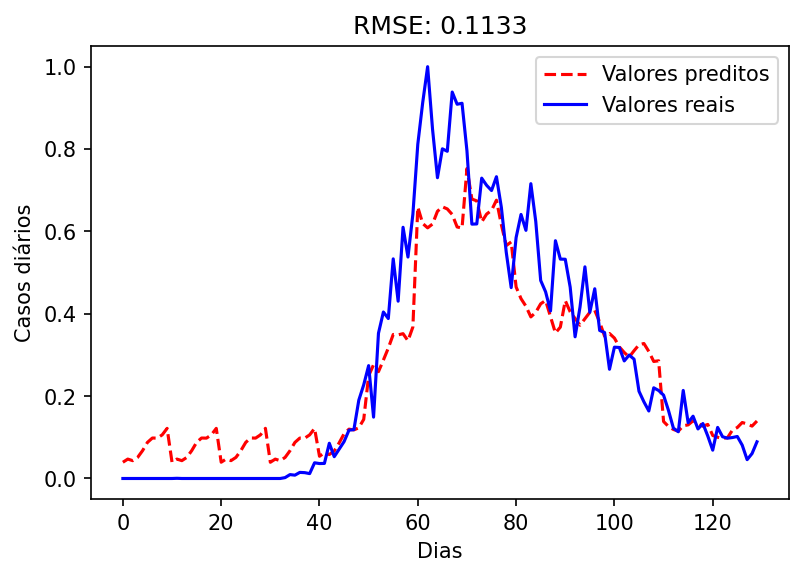

In [ ]:
# pontos de entrada
n_entrada = 20
# pontos de saida
n_saida = 10
score_portugal_1 = geraValidacao("Italy", "Modelo_Italy_v1", n_entrada, n_saida)

# Múltiplas execuções

Nesta seção, múltiplas execuções são feitas para teste dos parâmetros.

## Epoch único

**Canadá**

Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 4s 31ms/step - loss: 0.0267
Epoch 2/2
143/143 [==============================] - 4s 28ms/step - loss: 0.0136
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0374
Epoch 2/2
134/134 [==============================] - 4s 33ms/step - loss: 0.0148
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 4s 26ms/step - loss: 0.0364
Epoch 2/2
141/141 [==============================] - 3s 23ms/step - loss: 0.0212
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 3s 21ms/step - loss: 0.0294
Epoch 2/2
153/153 [==============================] - 3s 18ms/step - loss: 0.0143


<Figure size 432x288 with 0 Axes>

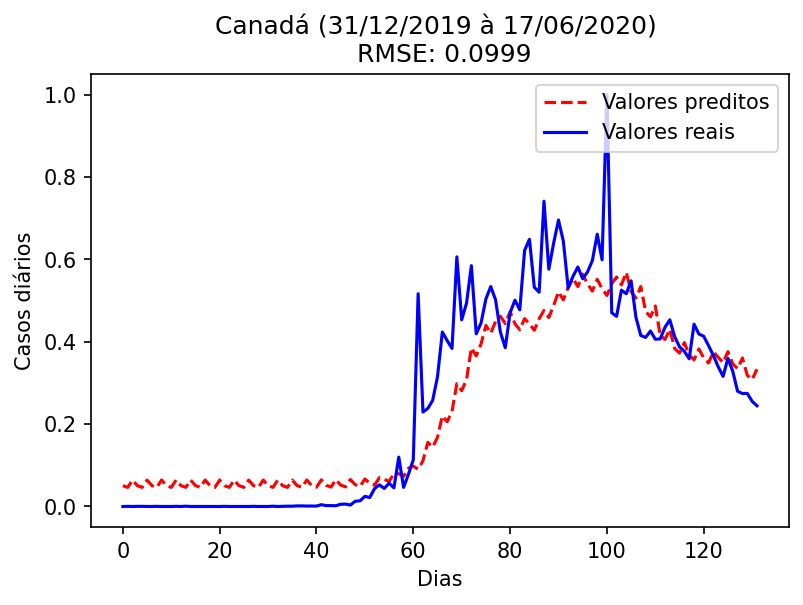

<Figure size 432x288 with 0 Axes>

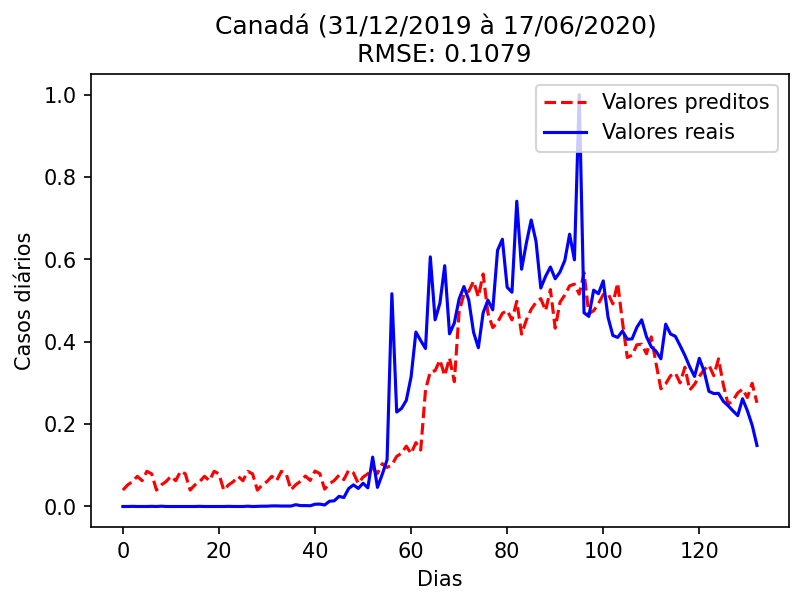

<Figure size 432x288 with 0 Axes>

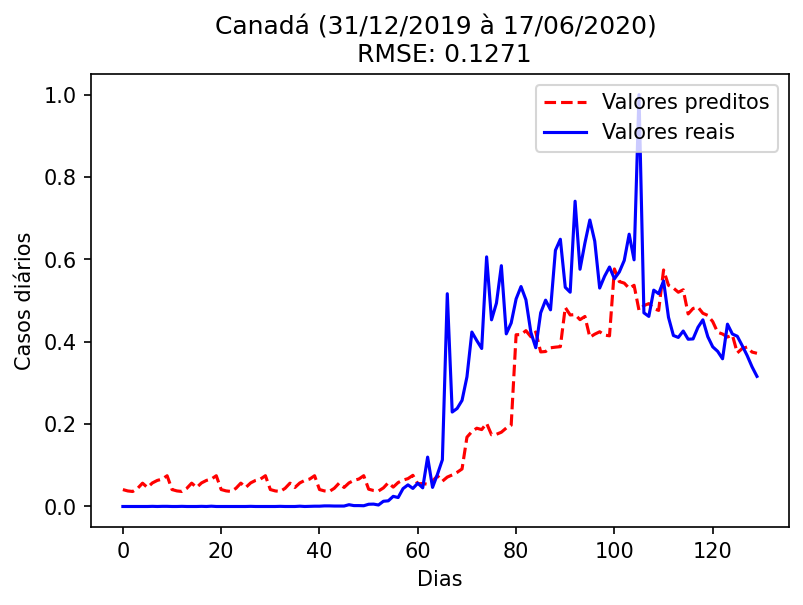

<Figure size 432x288 with 0 Axes>

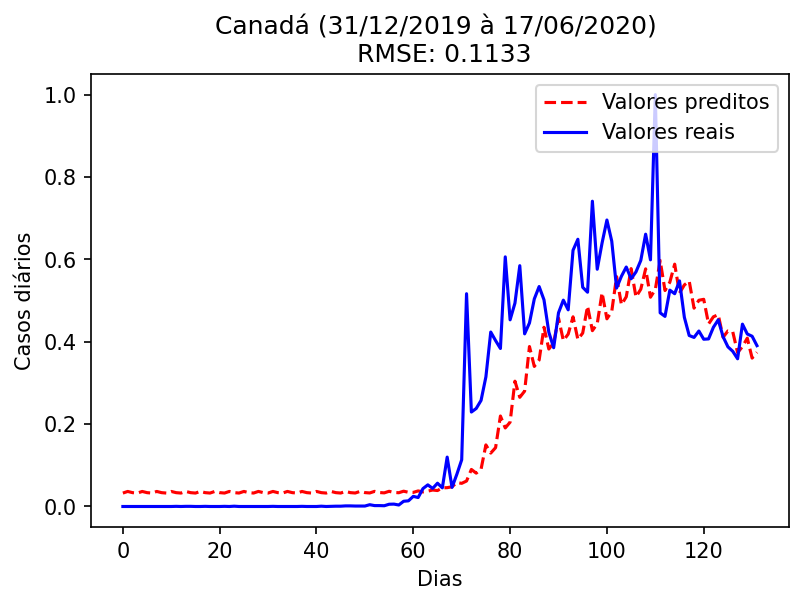

In [ ]:
can_params = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)], "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Cuba**

Modelo_Cuba_v0
Epoch 1/2
68/68 [==============================] - 2s 35ms/step - loss: 0.0748
Epoch 2/2
68/68 [==============================] - 2s 29ms/step - loss: 0.0411


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v1
Epoch 1/2
59/59 [==============================] - 2s 41ms/step - loss: 0.0715
Epoch 2/2
59/59 [==============================] - 2s 34ms/step - loss: 0.0450


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v2
Epoch 1/2
66/66 [==============================] - 2s 29ms/step - loss: 0.1038
Epoch 2/2
66/66 [==============================] - 2s 23ms/step - loss: 0.0619


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v3
Epoch 1/2
78/78 [==============================] - 2s 23ms/step - loss: 0.0709
Epoch 2/2
78/78 [==============================] - 1s 18ms/step - loss: 0.0426


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi


<Figure size 432x288 with 0 Axes>

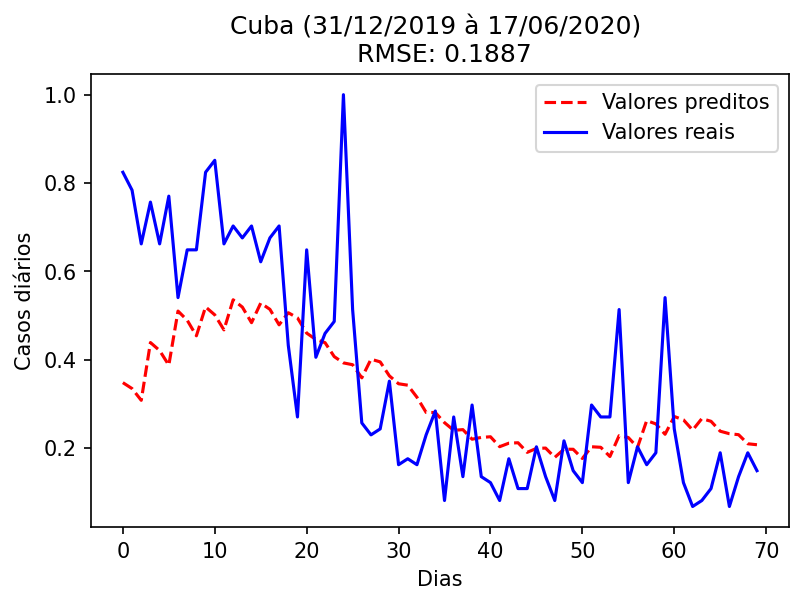

<Figure size 432x288 with 0 Axes>

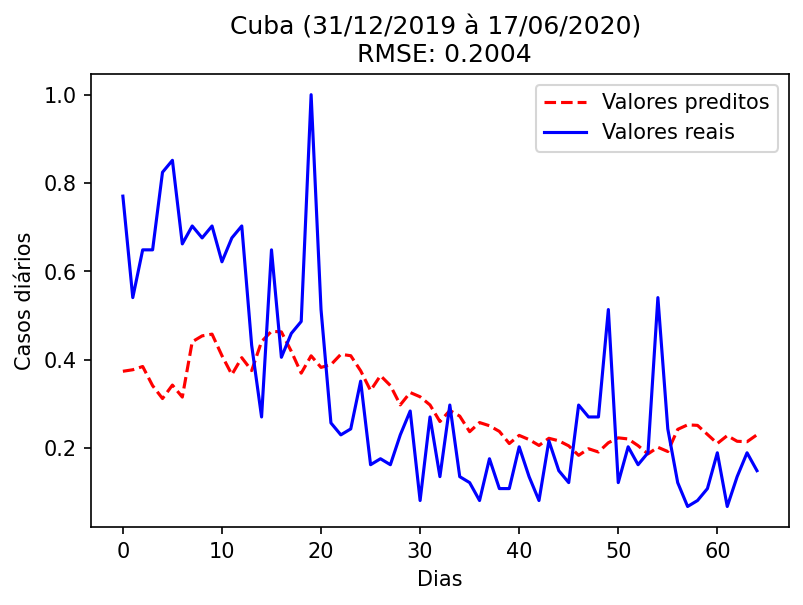

<Figure size 432x288 with 0 Axes>

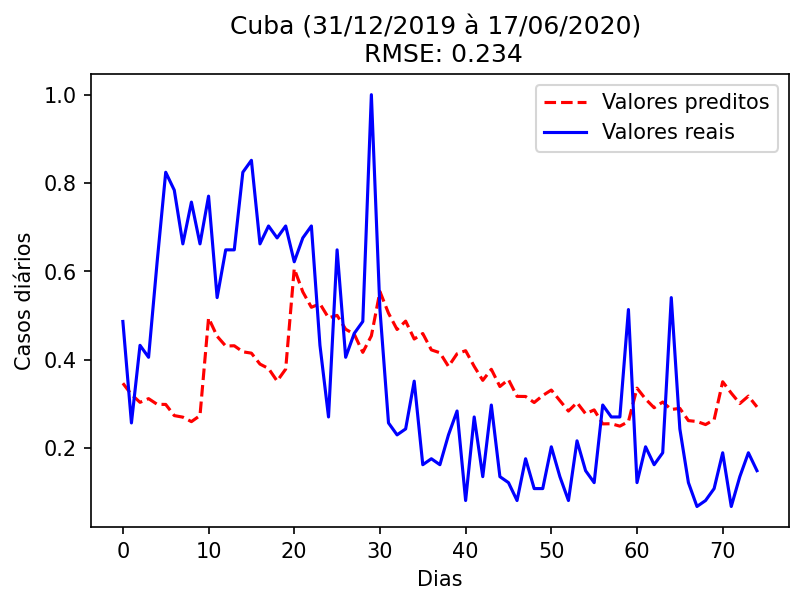

<Figure size 432x288 with 0 Axes>

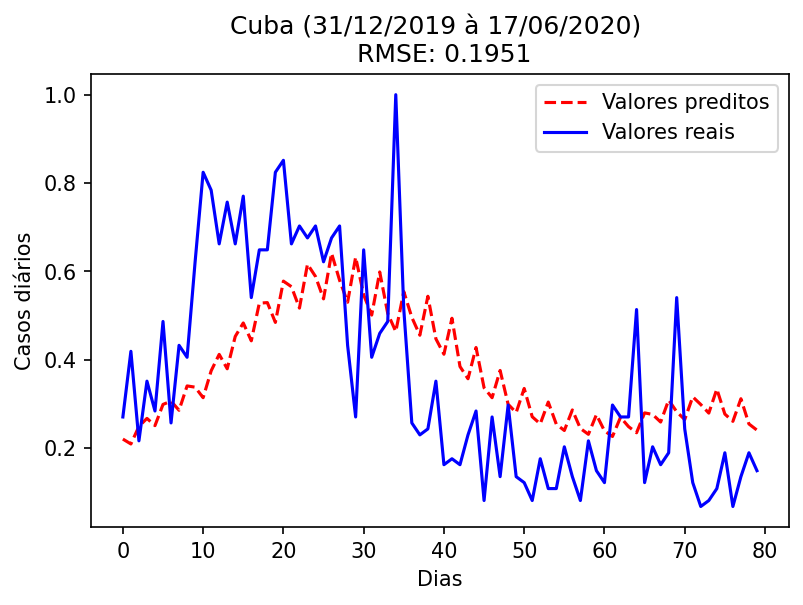

In [ ]:
cub_params = multiplas_execucoes("Cuba", [(25, 3), (30, 7), (20, 10), (15, 3)], "Cuba (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**México**

Modelo_Mexico_v0
Epoch 1/2
135/135 [==============================] - 4s 32ms/step - loss: 0.0173
Epoch 2/2
135/135 [==============================] - 4s 28ms/step - loss: 0.0049
Modelo_Mexico_v1
Epoch 1/2
126/126 [==============================] - 5s 39ms/step - loss: 0.0370
Epoch 2/2
126/126 [==============================] - 4s 34ms/step - loss: 0.0035
entrou condi
Modelo_Mexico_v2
Epoch 1/2
133/133 [==============================] - 3s 26ms/step - loss: 0.0385
Epoch 2/2
133/133 [==============================] - 3s 24ms/step - loss: 0.0036
Modelo_Mexico_v3
Epoch 1/2
145/145 [==============================] - 3s 21ms/step - loss: 0.0211
Epoch 2/2
145/145 [==============================] - 3s 19ms/step - loss: 0.0047


<Figure size 432x288 with 0 Axes>

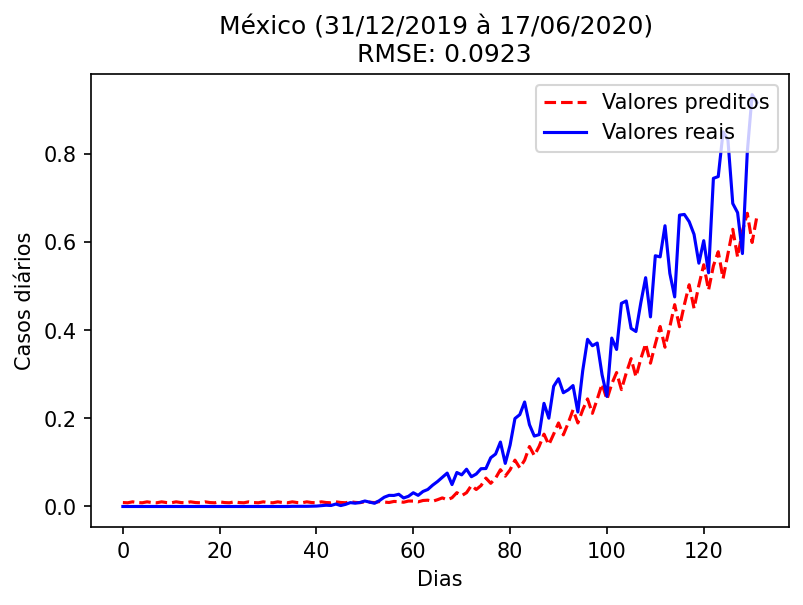

<Figure size 432x288 with 0 Axes>

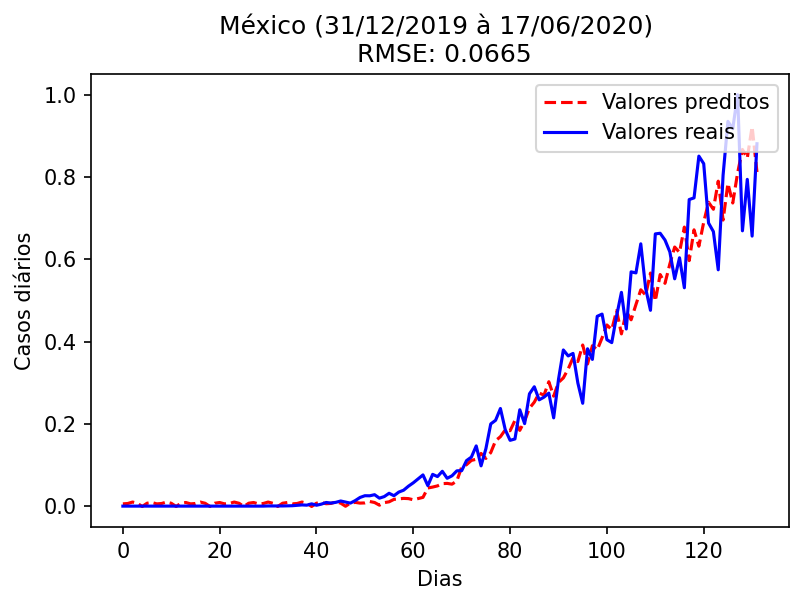

<Figure size 432x288 with 0 Axes>

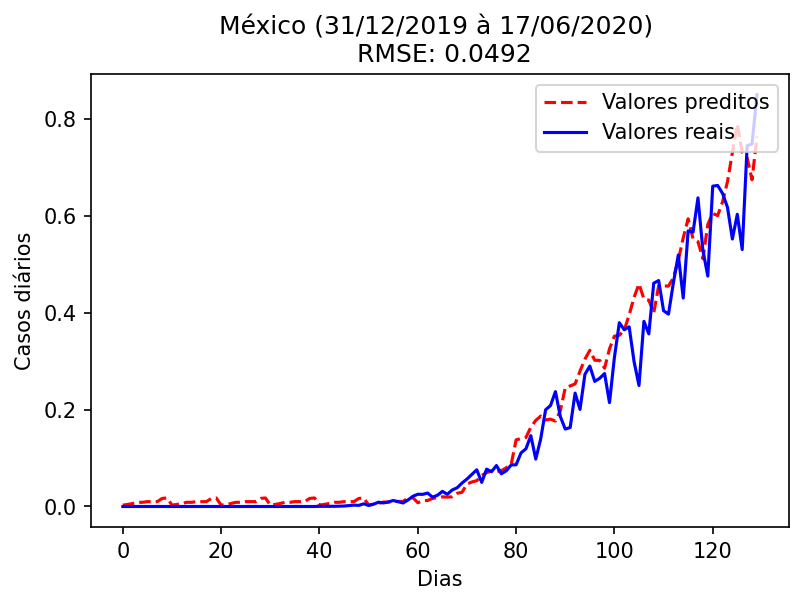

<Figure size 432x288 with 0 Axes>

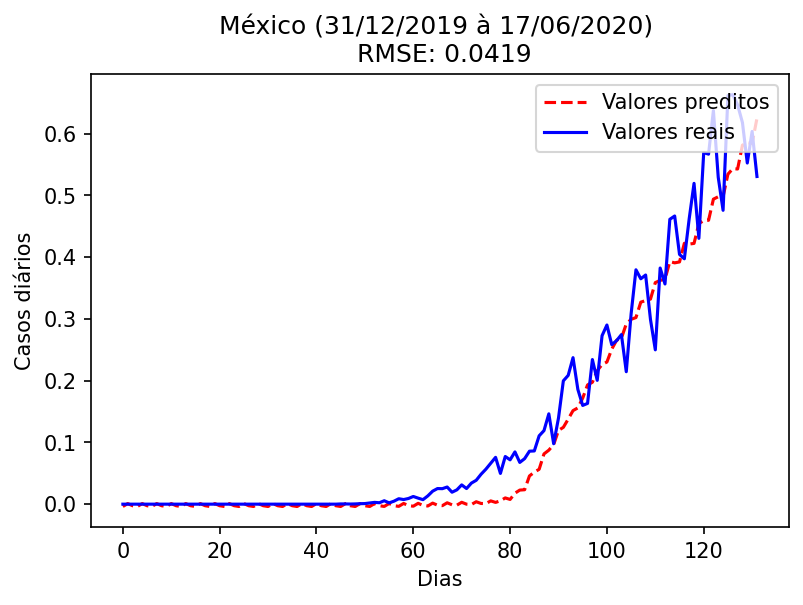

In [ ]:
mex_params = multiplas_execucoes("Mexico", [(25, 3), (30, 7), (20, 10), (15, 3)], "México (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Rússia**

Modelo_Russia_v0
Epoch 1/2
143/143 [==============================] - 5s 32ms/step - loss: 0.0605
Epoch 2/2
143/143 [==============================] - 4s 29ms/step - loss: 0.0080
Modelo_Russia_v1
Epoch 1/2
134/134 [==============================] - 5s 38ms/step - loss: 0.1825
Epoch 2/2
134/134 [==============================] - 5s 35ms/step - loss: 0.2881
Modelo_Russia_v2
Epoch 1/2
141/141 [==============================] - 4s 28ms/step - loss: 0.1017
Epoch 2/2
141/141 [==============================] - 3s 24ms/step - loss: 0.0315
Modelo_Russia_v3
Epoch 1/2
153/153 [==============================] - 3s 21ms/step - loss: 0.0321
Epoch 2/2
153/153 [==============================] - 3s 19ms/step - loss: 0.0073


<Figure size 432x288 with 0 Axes>

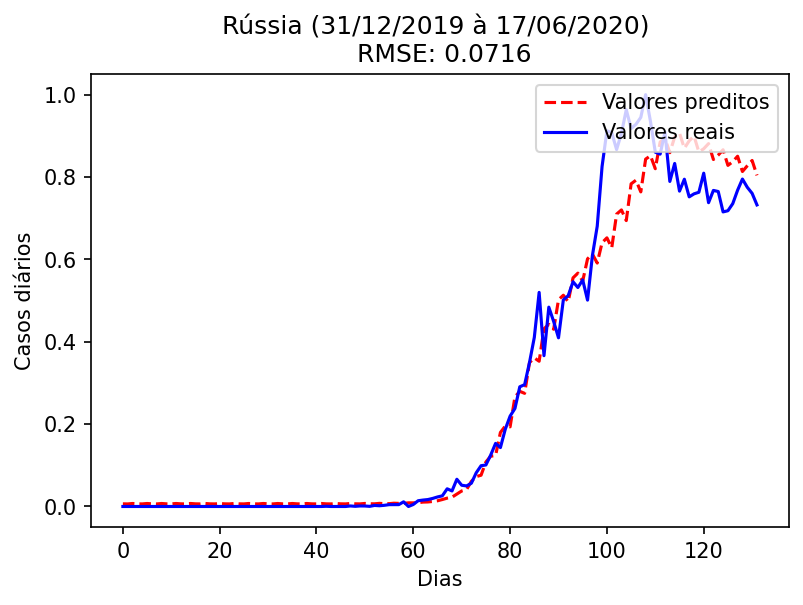

<Figure size 432x288 with 0 Axes>

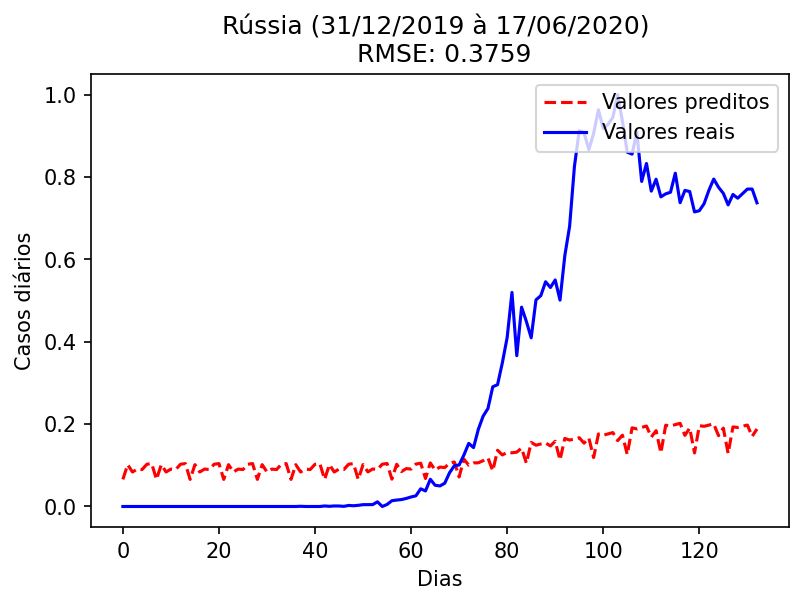

<Figure size 432x288 with 0 Axes>

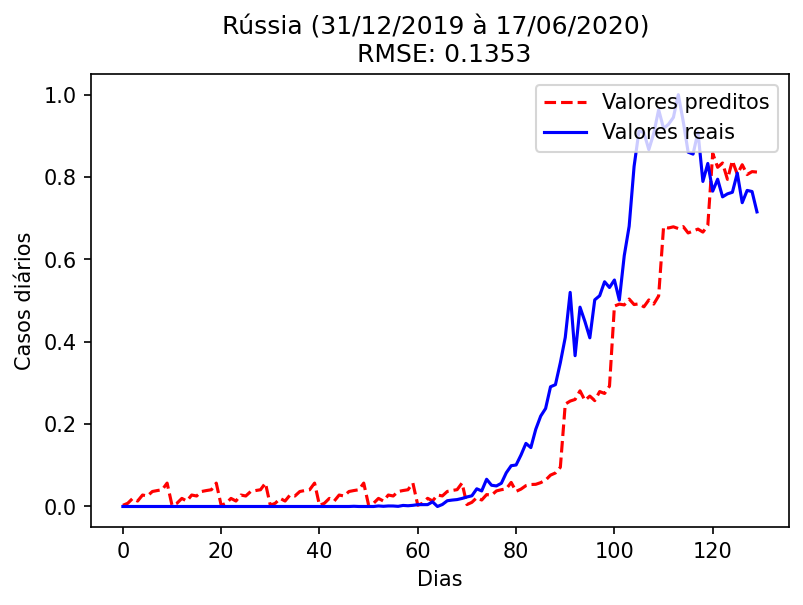

<Figure size 432x288 with 0 Axes>

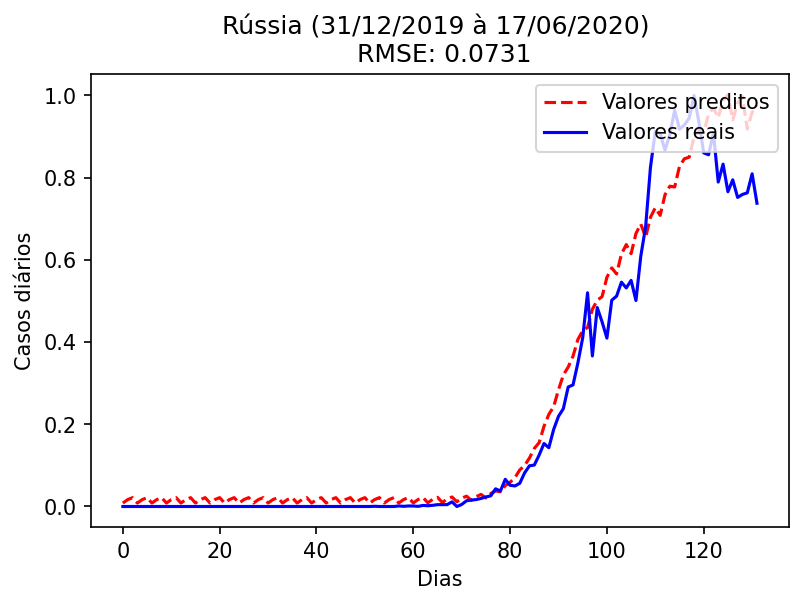

In [ ]:
rus_params = multiplas_execucoes("Russia", [(25, 3), (30, 7), (20, 10), (15, 3)], "Rússia (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

**Brasil**

Modelo_Brazil_v0
Epoch 1/2
143/143 [==============================] - 5s 32ms/step - loss: 0.0339
Epoch 2/2
143/143 [==============================] - 4s 29ms/step - loss: 0.0165
Modelo_Brazil_v1
Epoch 1/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0722
Epoch 2/2
134/134 [==============================] - 5s 35ms/step - loss: 0.0741
Modelo_Brazil_v2
Epoch 1/2
141/141 [==============================] - 4s 27ms/step - loss: 0.0434
Epoch 2/2
141/141 [==============================] - 3s 23ms/step - loss: 0.0123
Modelo_Brazil_v3
Epoch 1/2
153/153 [==============================] - 6s 38ms/step - loss: 0.0284
Epoch 2/2
153/153 [==============================] - 4s 23ms/step - loss: 0.0139


<Figure size 432x288 with 0 Axes>

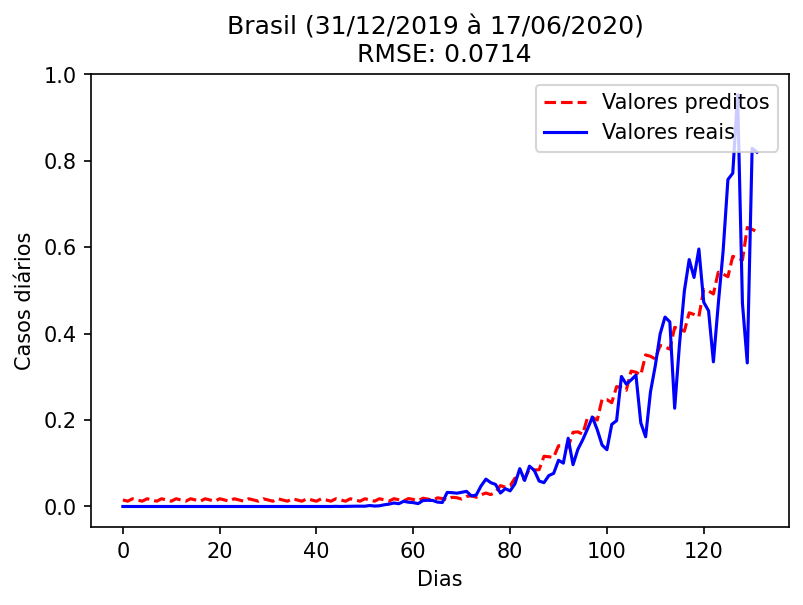

<Figure size 432x288 with 0 Axes>

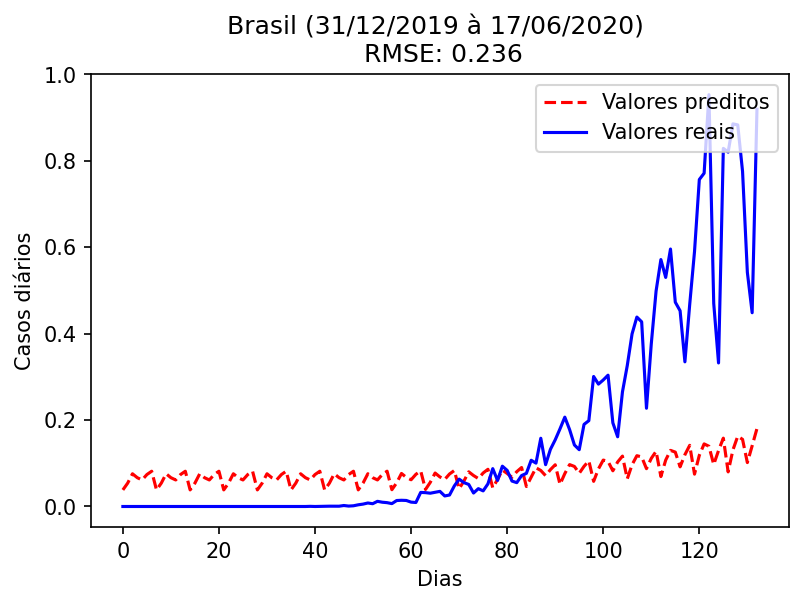

<Figure size 432x288 with 0 Axes>

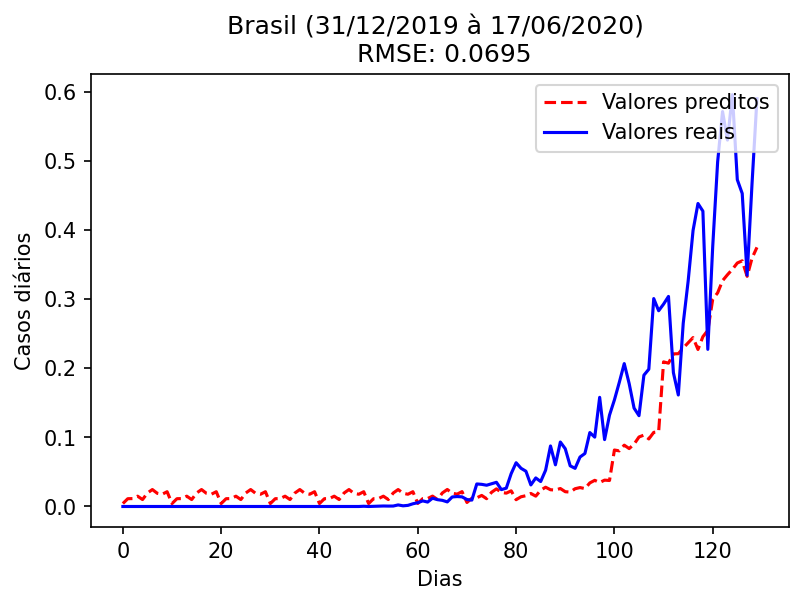

<Figure size 432x288 with 0 Axes>

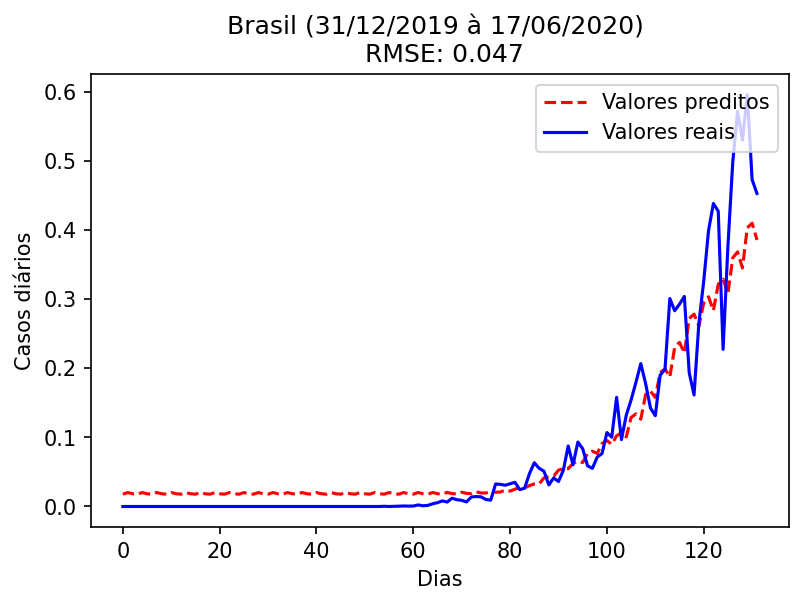

In [ ]:
bras_params = multiplas_execucoes("Brazil", [(25, 3), (30, 7), (20, 10), (15, 3)], "Brasil (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs = 2)

## Epoch múltiplos

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 5s 34ms/step - loss: 0.0285
Epoch 2/2
143/143 [==============================] - 4s 30ms/step - loss: 0.0126
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 5s 40ms/step - loss: 0.0775
Epoch 2/2
134/134 [==============================] - 5s 35ms/step - loss: 0.0298
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 4s 27ms/step - loss: 0.0447
Epoch 2/2
141/141 [==============================] - 3s 24ms/step - loss: 0.0221
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 3s 22ms/step - loss: 0.0229
Epoch 2/2
153/153 [==============================] - 3s 19ms/step - loss: 0.0129
Modelo_Canada_v0
Epoch 1/3
143/143 [==============================] - 5s 33ms/step - loss: 0.0300
Epoch 2/3
143/143 [==============================] - 4s 29ms/step - loss: 0.0128
Epoch 3/3
143/143 [==============================] - 5s 32ms/step - loss: 0.0100
Modelo_Canada_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Canada_v3
Epoch 1/4
153/153 [==============================] - 3s 23ms/step - loss: 0.0231
Epoch 2/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0120
Epoch 3/4
153/153 [==============================] - 3s 19ms/step - loss: 0.0100
Epoch 4/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

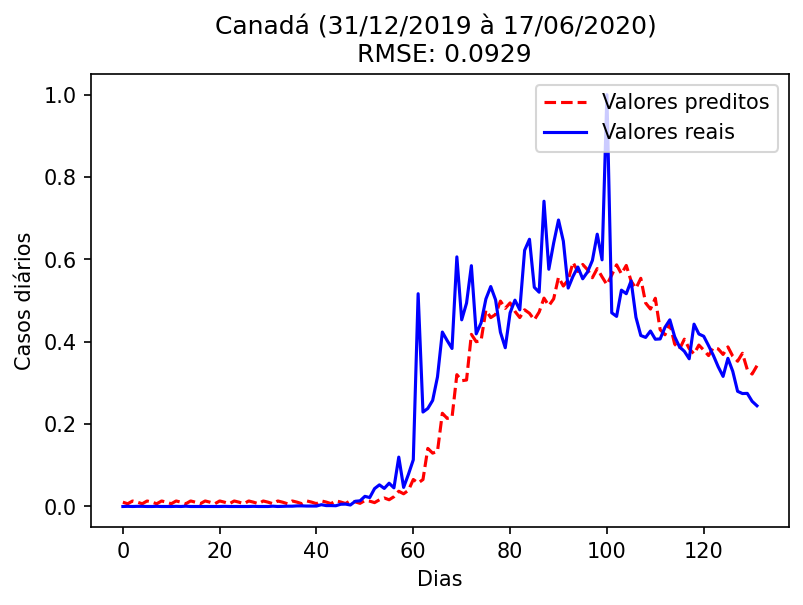

<Figure size 432x288 with 0 Axes>

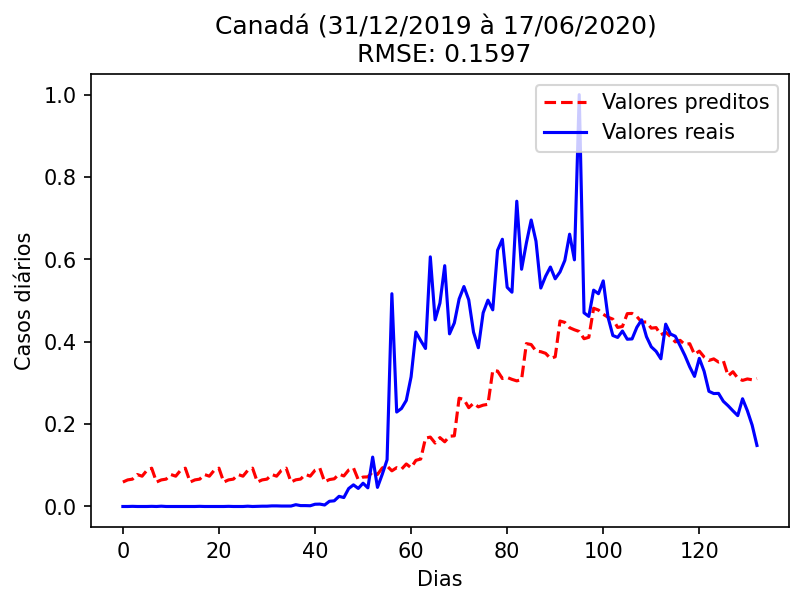

<Figure size 432x288 with 0 Axes>

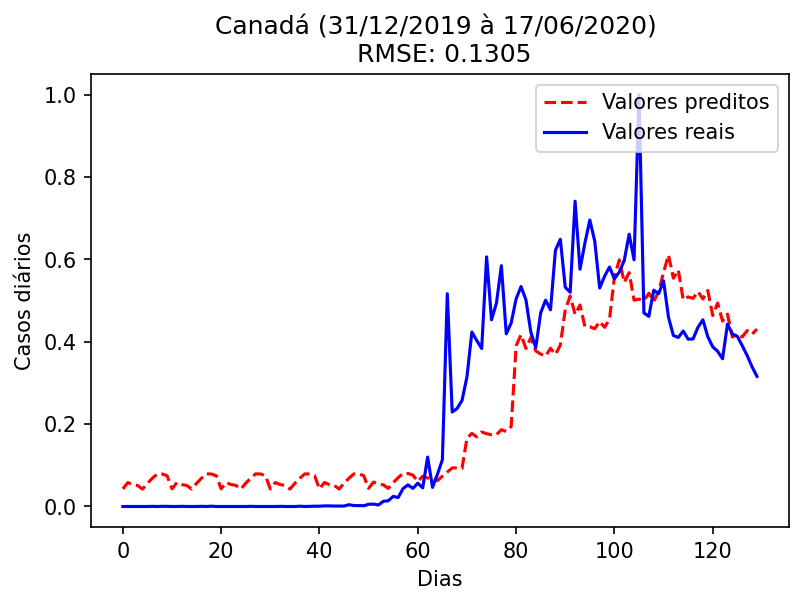

<Figure size 432x288 with 0 Axes>

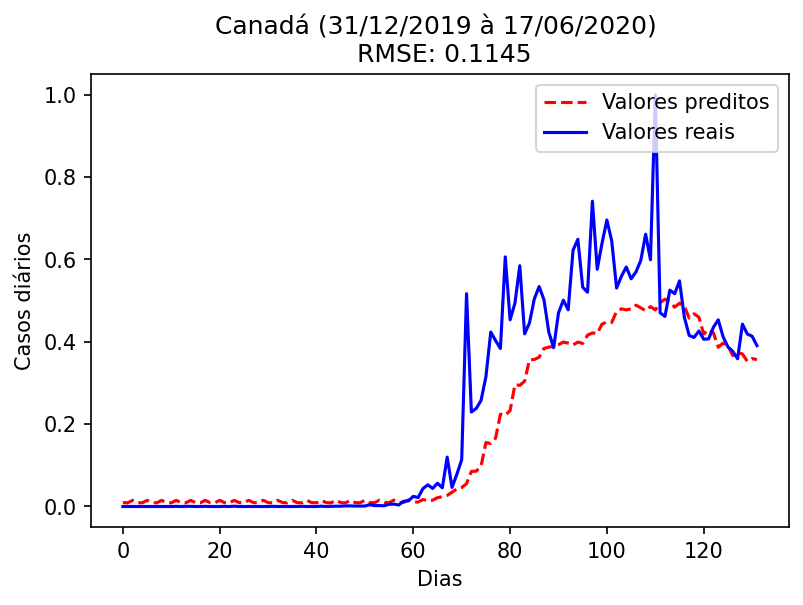

<Figure size 432x288 with 0 Axes>

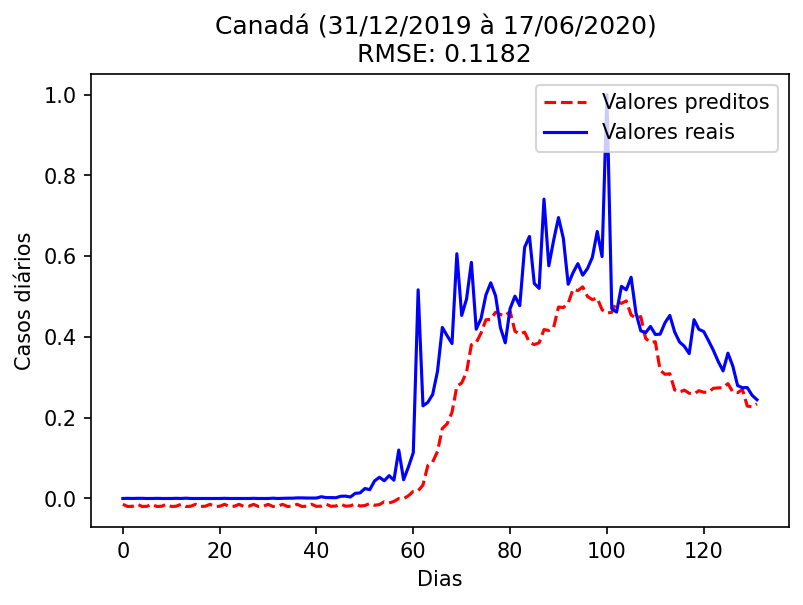

<Figure size 432x288 with 0 Axes>

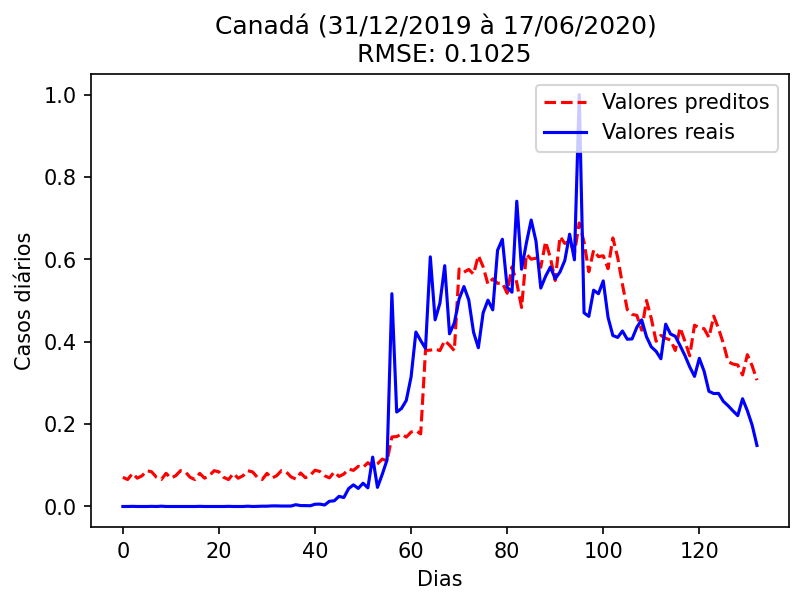

<Figure size 432x288 with 0 Axes>

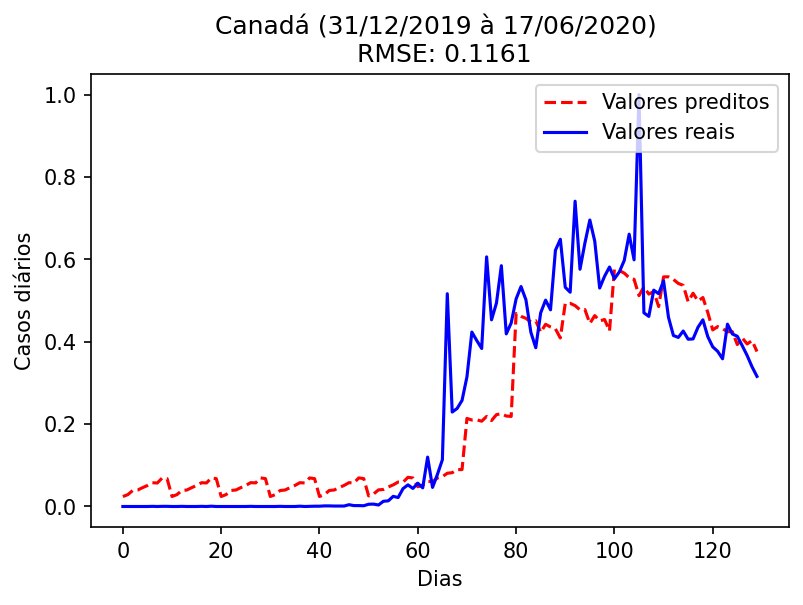

<Figure size 432x288 with 0 Axes>

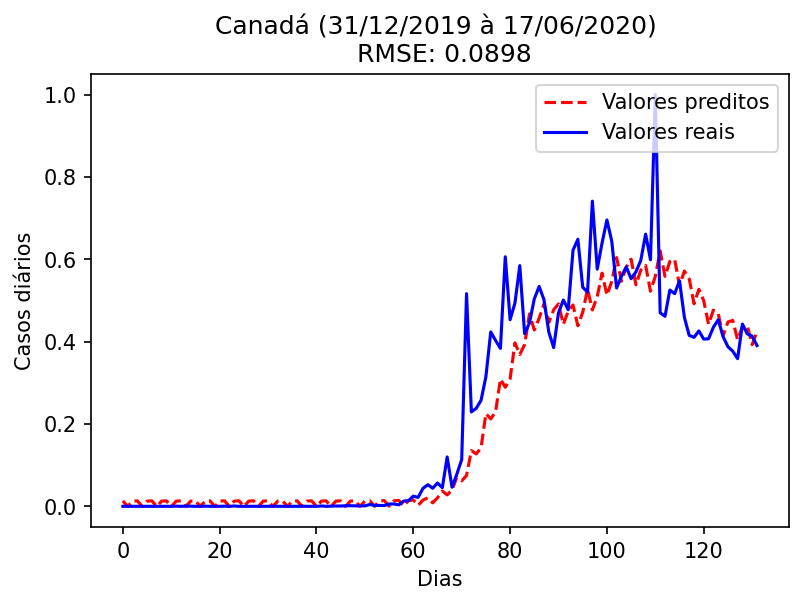

<Figure size 432x288 with 0 Axes>

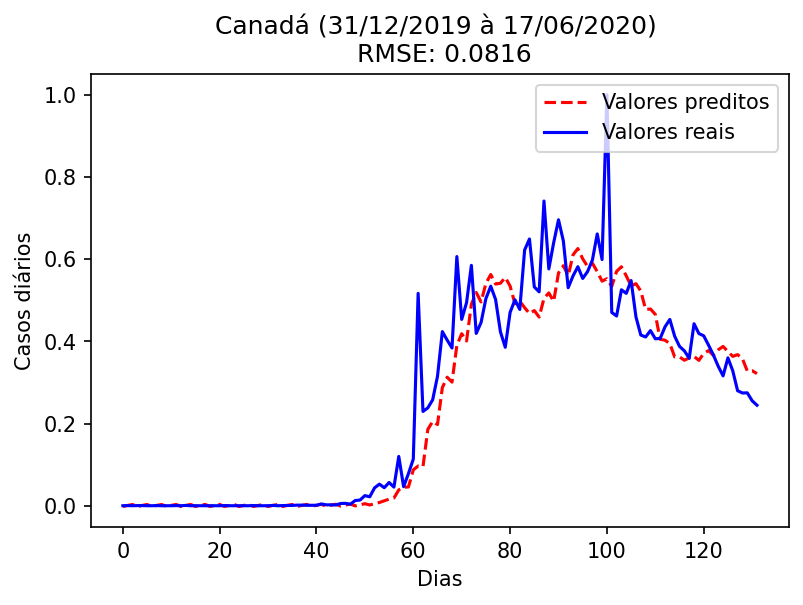

<Figure size 432x288 with 0 Axes>

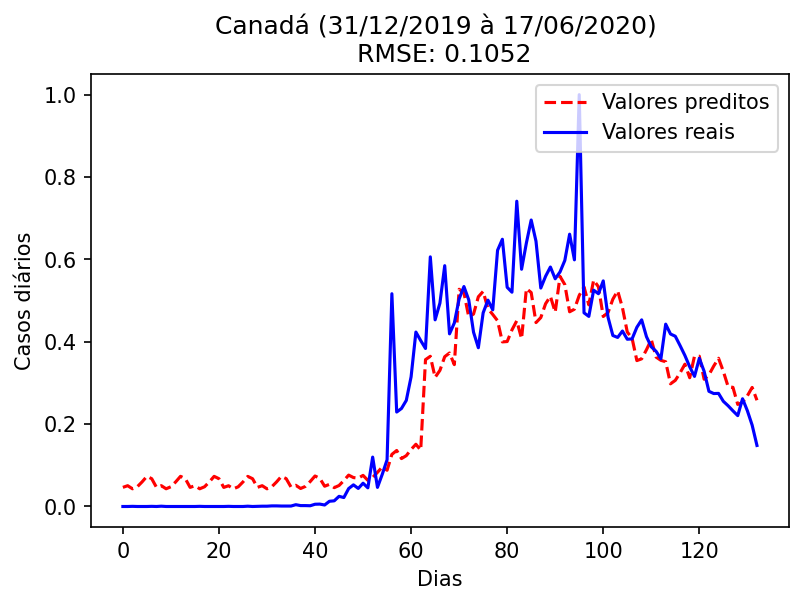

<Figure size 432x288 with 0 Axes>

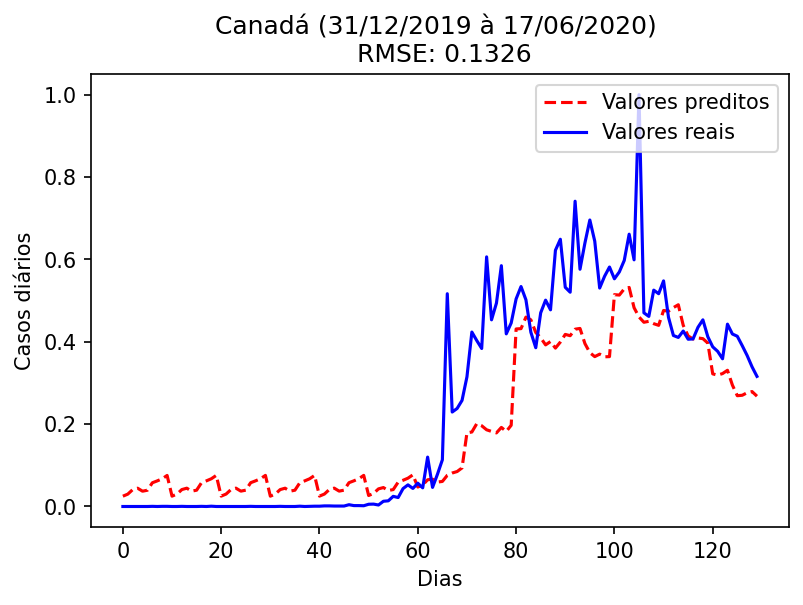

<Figure size 432x288 with 0 Axes>

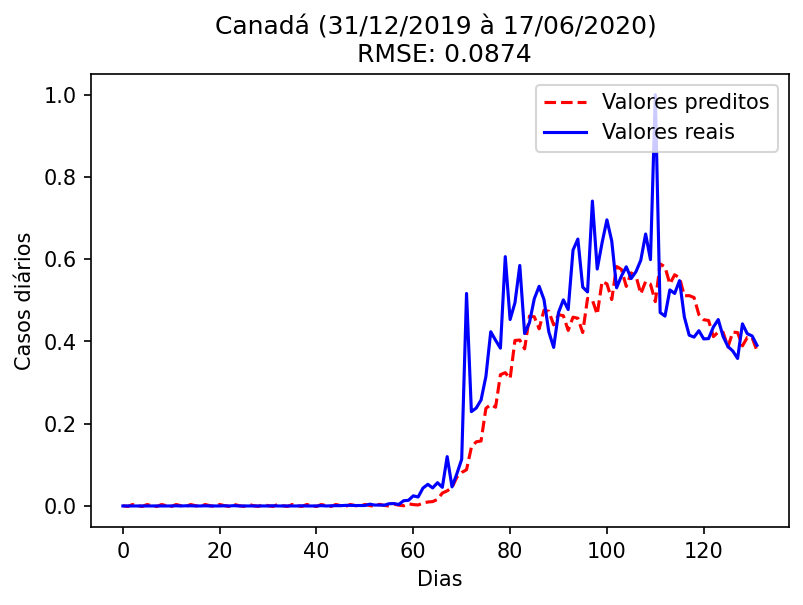

In [ ]:
can_paramsrange = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)],
                                      "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", 
                                      epochs_range = (2, 5))

**Canadá**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Canada_v0
Epoch 1/2
143/143 [==============================] - 5s 33ms/step - loss: 0.0337
Epoch 2/2
143/143 [==============================] - 4s 29ms/step - loss: 0.0149
Modelo_Canada_v1
Epoch 1/2
134/134 [==============================] - 5s 39ms/step - loss: 0.0438
Epoch 2/2
134/134 [==============================] - 5s 36ms/step - loss: 0.0211
Modelo_Canada_v2
Epoch 1/2
141/141 [==============================] - 4s 28ms/step - loss: 0.0381
Epoch 2/2
141/141 [==============================] - 3s 23ms/step - loss: 0.0215
Modelo_Canada_v3
Epoch 1/2
153/153 [==============================] - 3s 21ms/step - loss: 0.0304
Epoch 2/2
153/153 [==============================] - 3s 19ms/step - loss: 0.0122
Modelo_Canada_v0
Epoch 1/3
143/143 [==============================] - 5s 32ms/step - loss: 0.0287
Epoch 2/3
143/143 [==============================] - 4s 29ms/step - loss: 0.0148
Epoch 3/3
143/143 [==============================] - 4s 29ms/step - loss: 0.0107
Modelo_Canada_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Canada_v3
Epoch 1/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0216
Epoch 2/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0131
Epoch 3/4
153/153 [==============================] - 3s 19ms/step - loss: 0.0112
Epoch 4/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0096


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

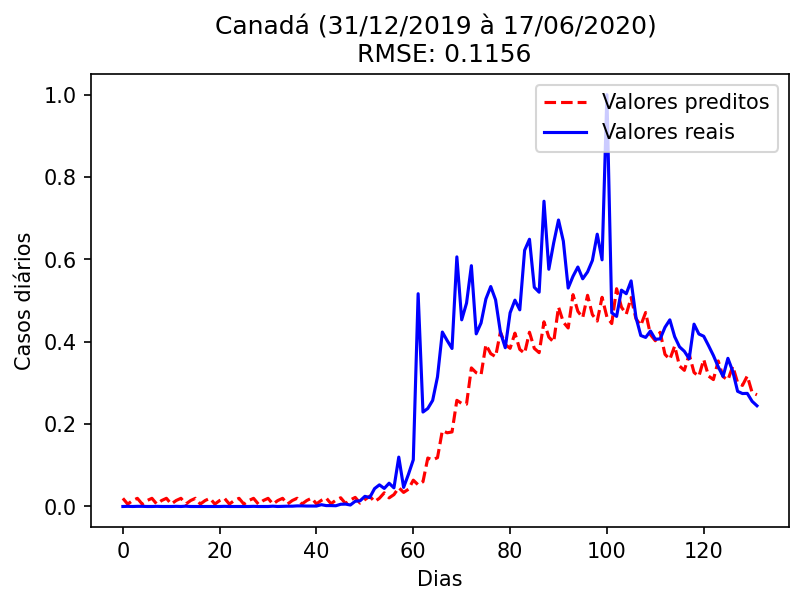

<Figure size 432x288 with 0 Axes>

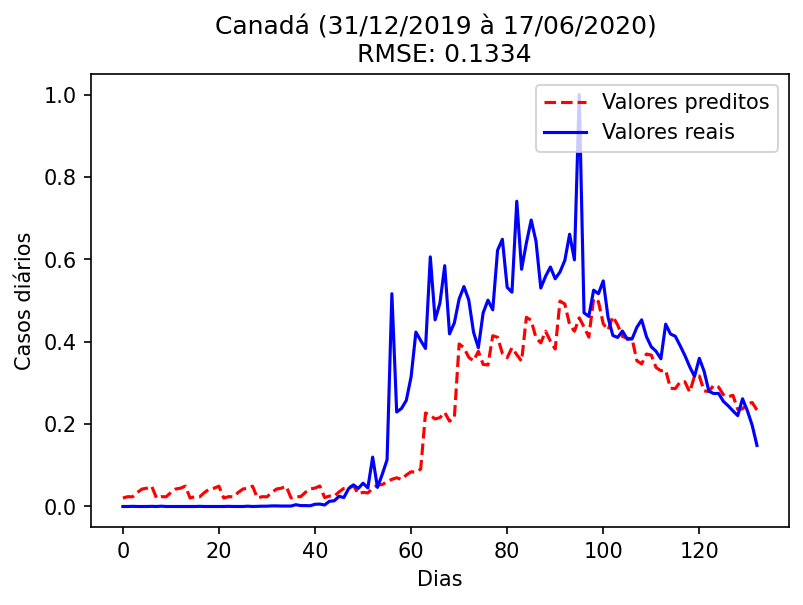

<Figure size 432x288 with 0 Axes>

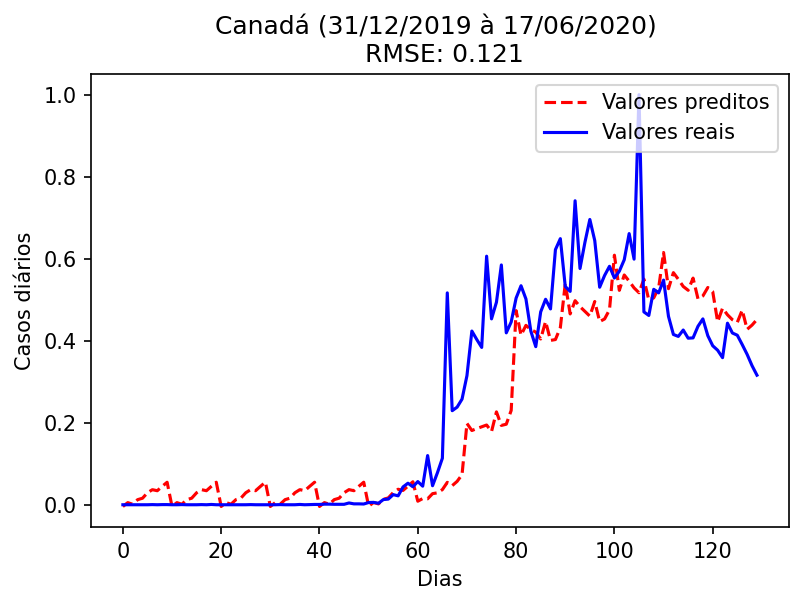

<Figure size 432x288 with 0 Axes>

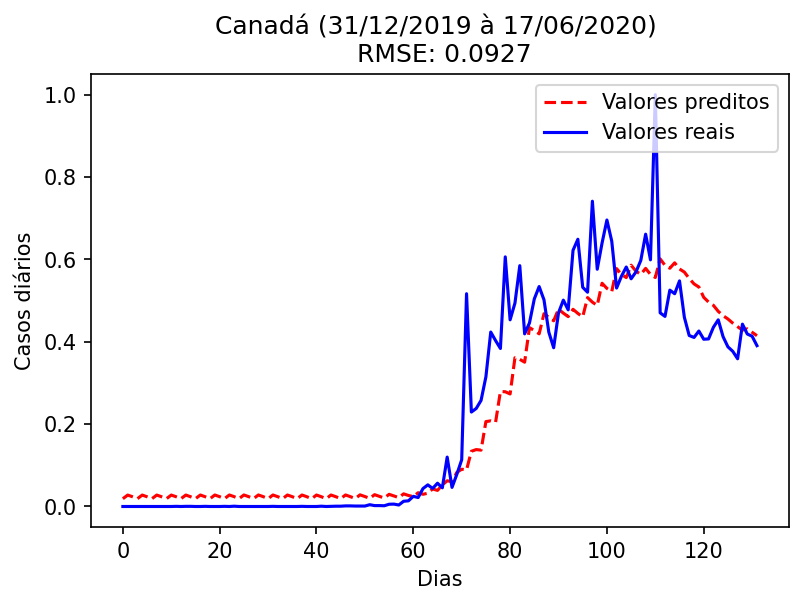

<Figure size 432x288 with 0 Axes>

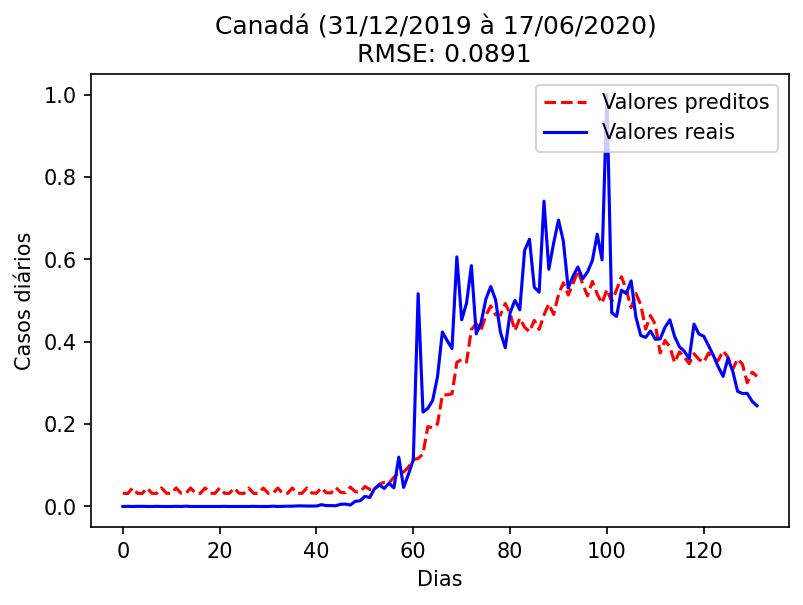

<Figure size 432x288 with 0 Axes>

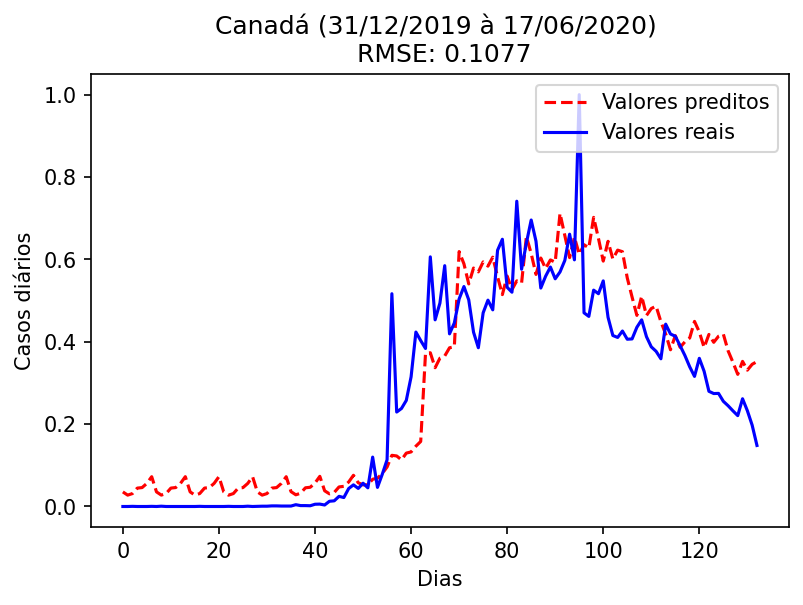

<Figure size 432x288 with 0 Axes>

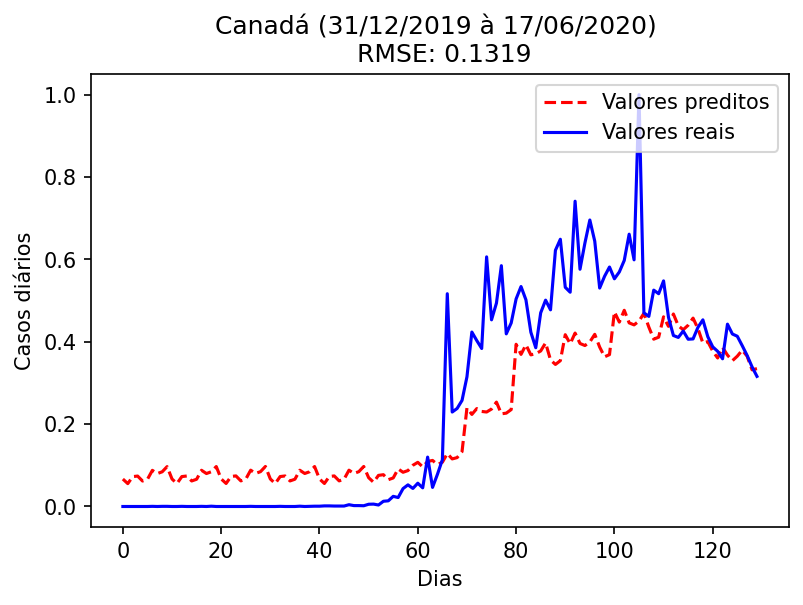

<Figure size 432x288 with 0 Axes>

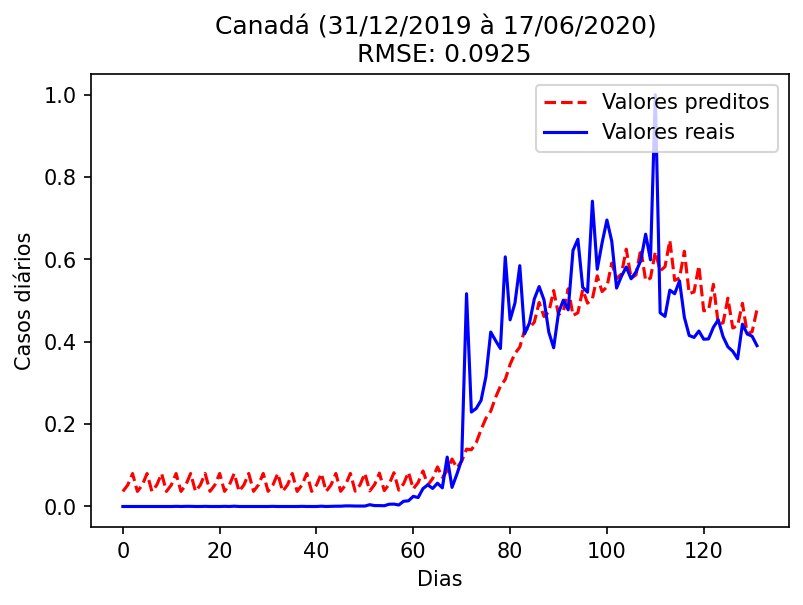

<Figure size 432x288 with 0 Axes>

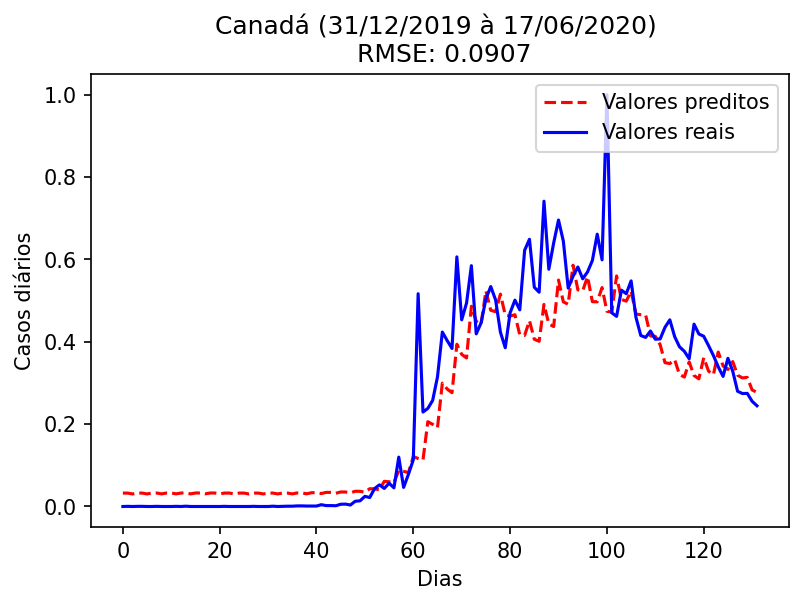

<Figure size 432x288 with 0 Axes>

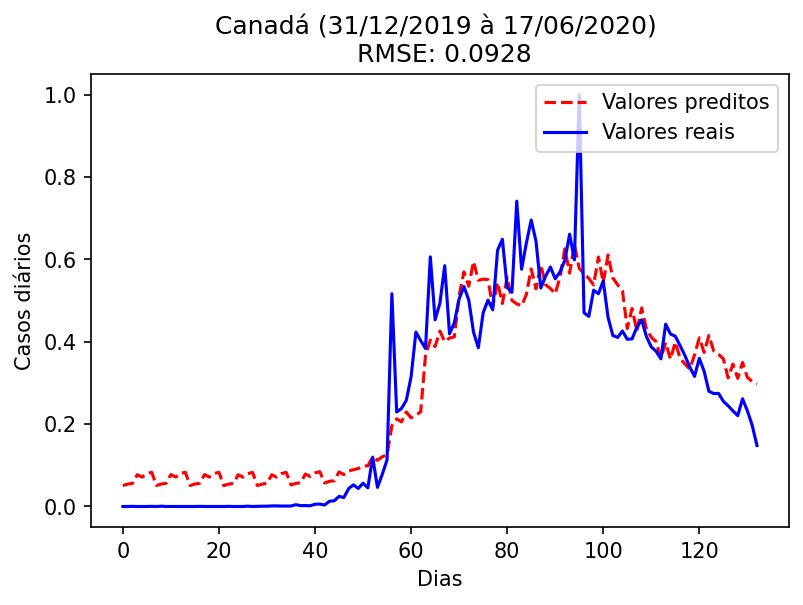

<Figure size 432x288 with 0 Axes>

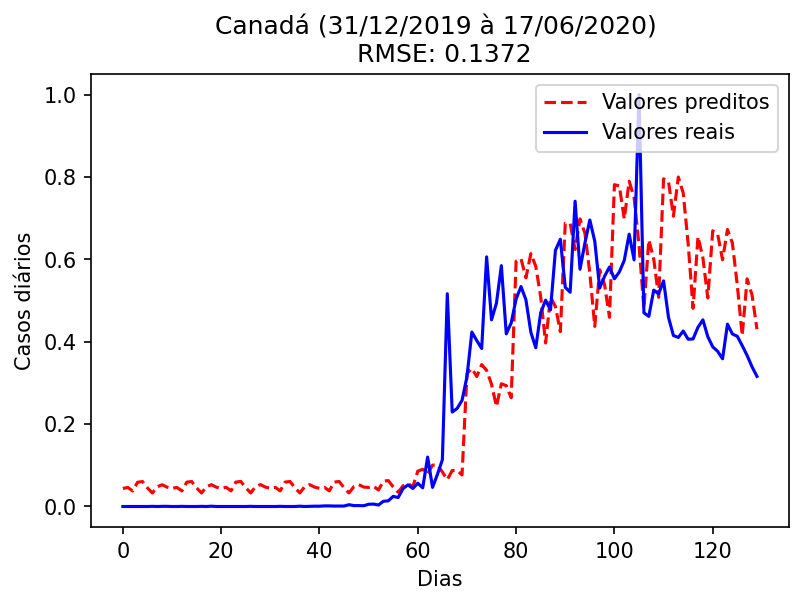

<Figure size 432x288 with 0 Axes>

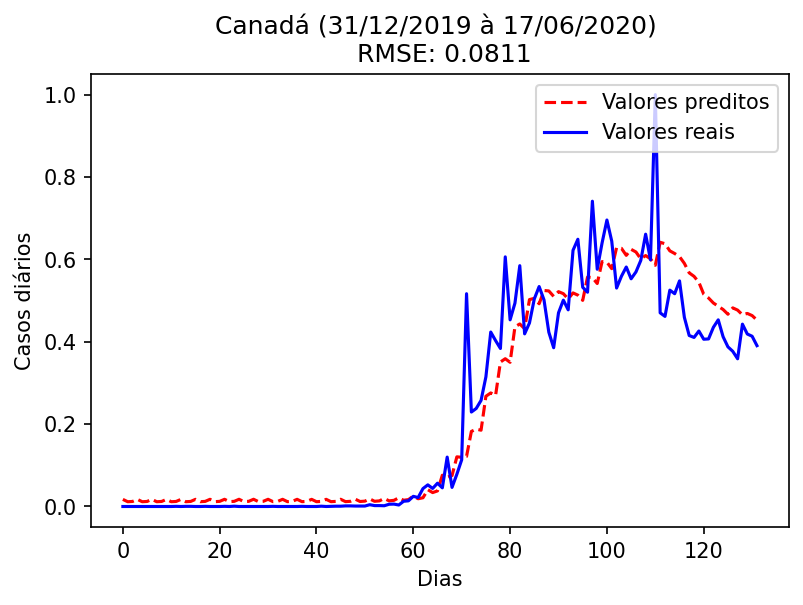

In [ ]:
can_paramsrange = multiplas_execucoes("Canada", [(25, 3), (30, 7), (20, 10), (15, 3)],
                                      "Canadá (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Cuba**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Cuba_v0
Epoch 1/2
68/68 [==============================] - 2s 35ms/step - loss: 0.0718
Epoch 2/2
68/68 [==============================] - 2s 30ms/step - loss: 0.0466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v1
Epoch 1/2
59/59 [==============================] - 2s 42ms/step - loss: 0.1067
Epoch 2/2
59/59 [==============================] - 2s 35ms/step - loss: 0.0444


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v2
Epoch 1/2
66/66 [==============================] - 2s 30ms/step - loss: 0.1279
Epoch 2/2
66/66 [==============================] - 2s 23ms/step - loss: 0.0712


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v3
Epoch 1/2
78/78 [==============================] - 2s 26ms/step - loss: 0.0620
Epoch 2/2
78/78 [==============================] - 1s 18ms/step - loss: 0.0445


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v0
Epoch 1/3
68/68 [==============================] - 2s 37ms/step - loss: 0.0566
Epoch 2/3
68/68 [==============================] - 2s 30ms/step - loss: 0.0489
Epoch 3/3
68/68 [==============================] - 2s 28ms/step - loss: 0.0410


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v1
Epoch 1/3
59/59 [==============================] - 3s 43ms/step - loss: 0.0708
Epoch 2/3
59/59 [==============================] - 2s 33ms/step - loss: 0.0509
Epoch 3/3
59/59 [==============================] - 2s 34ms/step - loss: 0.0370


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v2
Epoch 1/3
66/66 [==============================] - 2s 30ms/step - loss: 0.0876
Epoch 2/3
66/66 [==============================] - 2s 26ms/step - loss: 0.0594
Epoch 3/3
66/66 [==============================] - 2s 25ms/step - loss: 0.0523


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v3
Epoch 1/3
78/78 [==============================] - 2s 26ms/step - loss: 0.0660
Epoch 2/3
78/78 [==============================] - 2s 20ms/step - loss: 0.0420
Epoch 3/3
78/78 [==============================] - 1s 19ms/step - loss: 0.0385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v0
Epoch 1/4
68/68 [==============================] - 3s 37ms/step - loss: 0.0750
Epoch 2/4
68/68 [==============================] - 2s 29ms/step - loss: 0.0486
Epoch 3/4
68/68 [==============================] - 2s 29ms/step - loss: 0.0400
Epoch 4/4
68/68 [==============================] - 2s 29ms/step - loss: 0.0356


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v1
Epoch 1/4
59/59 [==============================] - 3s 43ms/step - loss: 0.0754
Epoch 2/4
59/59 [==============================] - 2s 33ms/step - loss: 0.0392
Epoch 3/4
59/59 [==============================] - 2s 34ms/step - loss: 0.0326
Epoch 4/4
59/59 [==============================] - 2s 35ms/step - loss: 0.0238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição


entrou condi
Modelo_Cuba_v2
Epoch 1/4
66/66 [==============================] - 2s 30ms/step - loss: 0.0855
Epoch 2/4
66/66 [==============================] - 2s 23ms/step - loss: 0.0583
Epoch 3/4
66/66 [==============================] - 2s 23ms/step - loss: 0.0504
Epoch 4/4
66/66 [==============================] - 2s 24ms/step - loss: 0.0485


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi
Modelo_Cuba_v3
Epoch 1/4
78/78 [==============================] - 2s 26ms/step - loss: 0.0603
Epoch 2/4
78/78 [==============================] - 1s 18ms/step - loss: 0.0449
Epoch 3/4
78/78 [==============================] - 1s 19ms/step - loss: 0.0369
Epoch 4/4
78/78 [==============================] - 1s 18ms/step - loss: 0.0346


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: Problema na lógica de separação para predição
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


entrou condi


<Figure size 432x288 with 0 Axes>

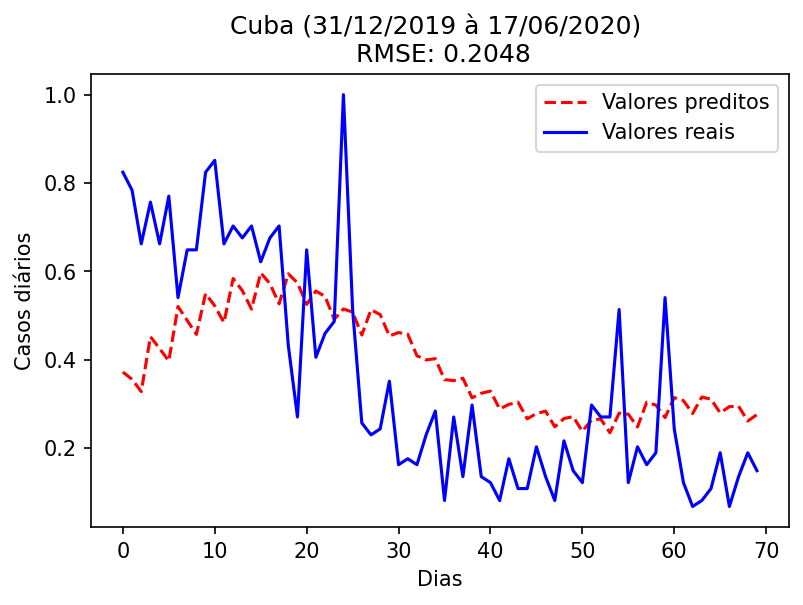

<Figure size 432x288 with 0 Axes>

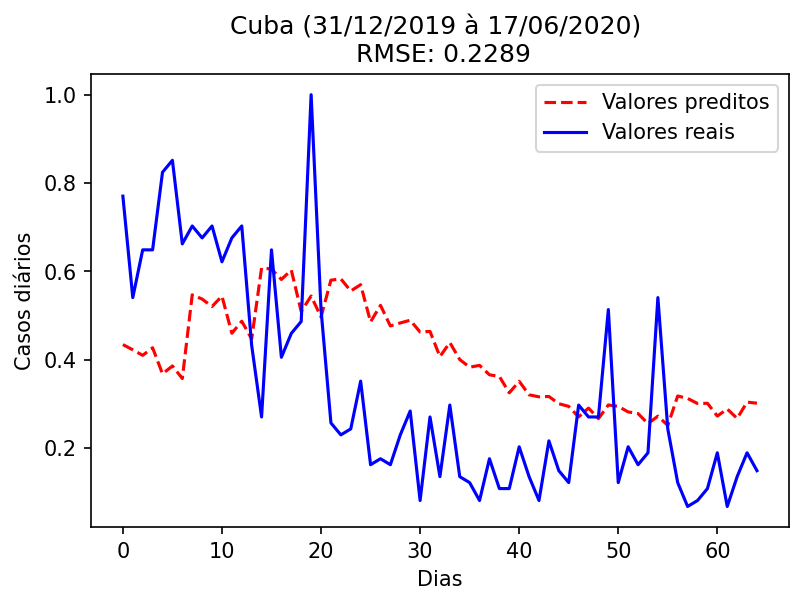

<Figure size 432x288 with 0 Axes>

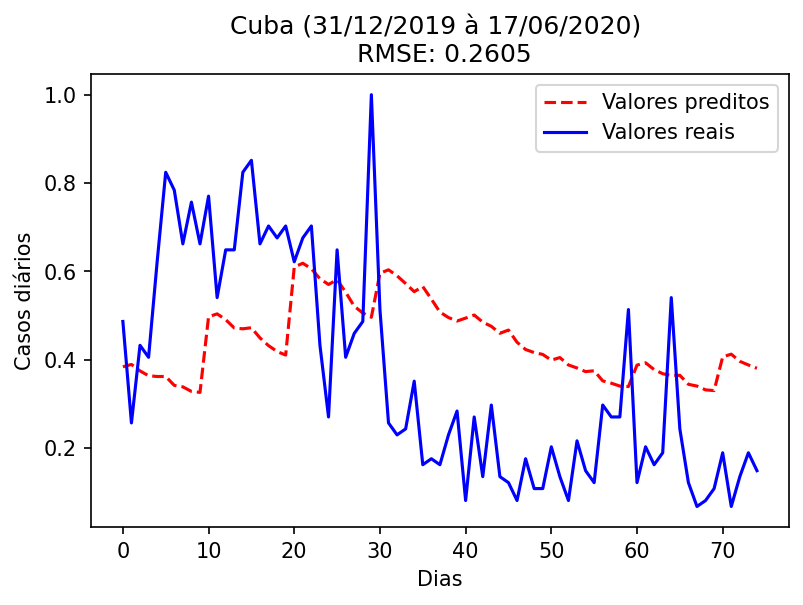

<Figure size 432x288 with 0 Axes>

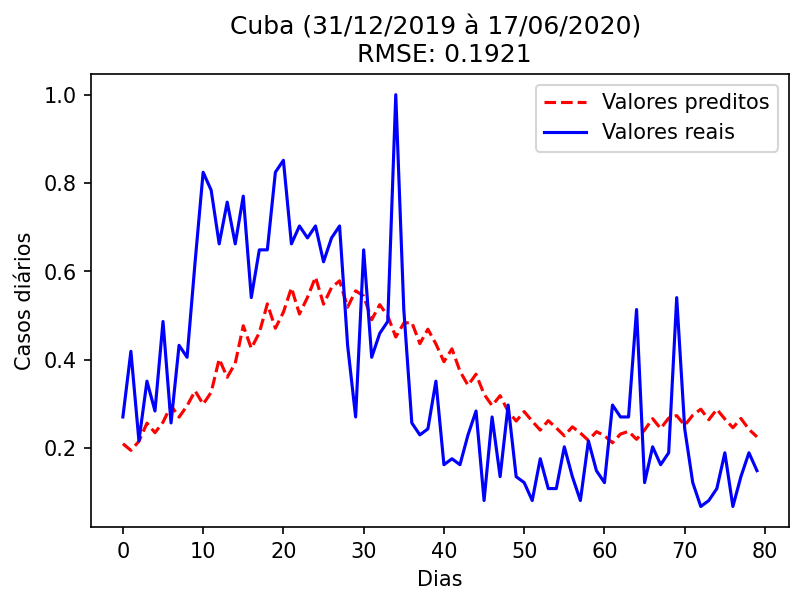

<Figure size 432x288 with 0 Axes>

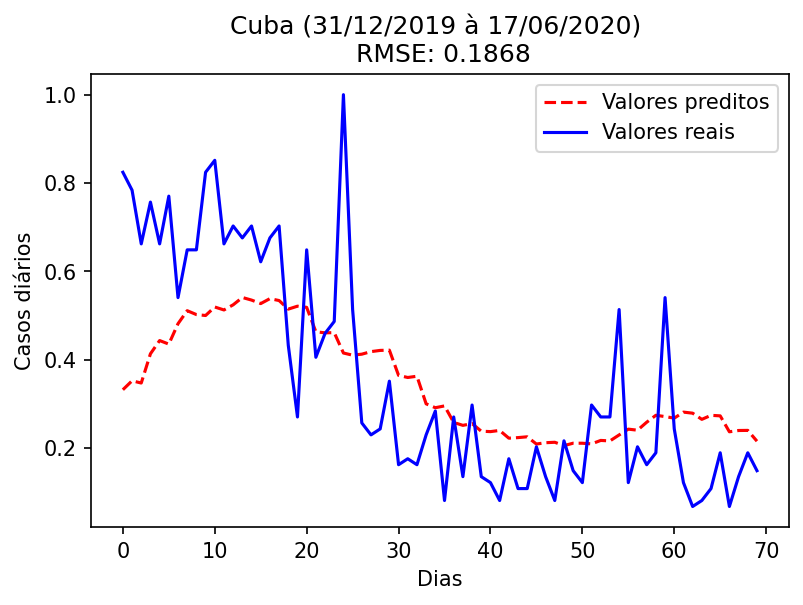

<Figure size 432x288 with 0 Axes>

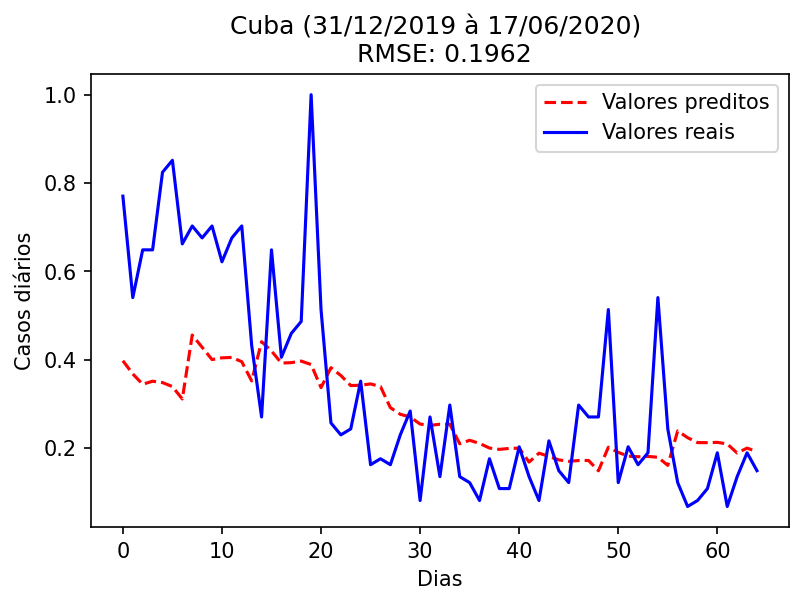

<Figure size 432x288 with 0 Axes>

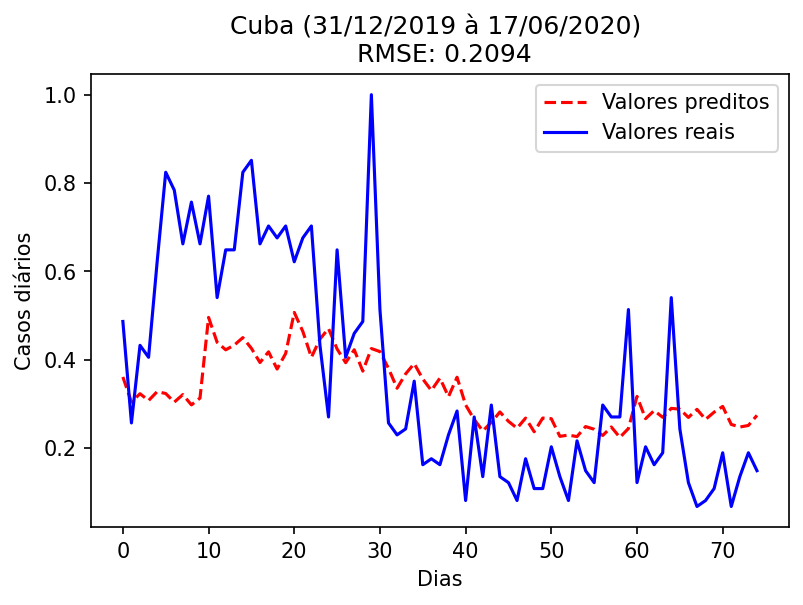

<Figure size 432x288 with 0 Axes>

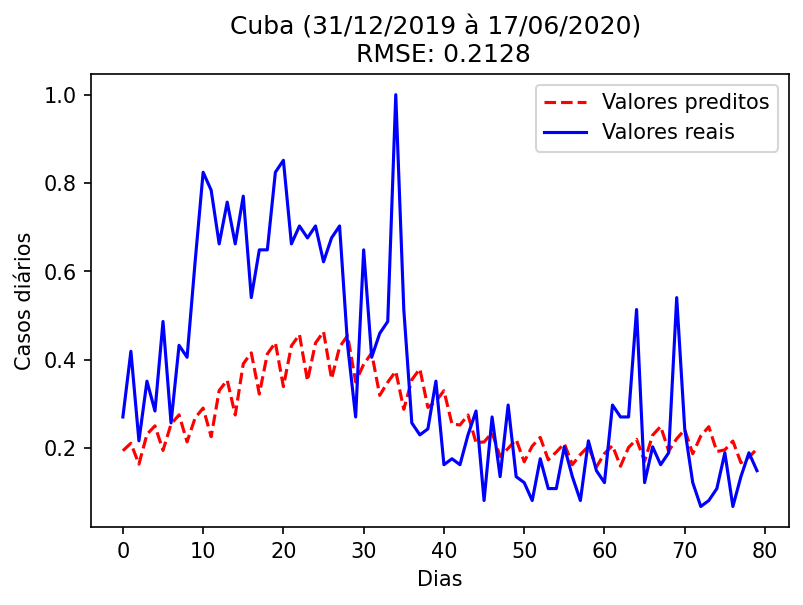

<Figure size 432x288 with 0 Axes>

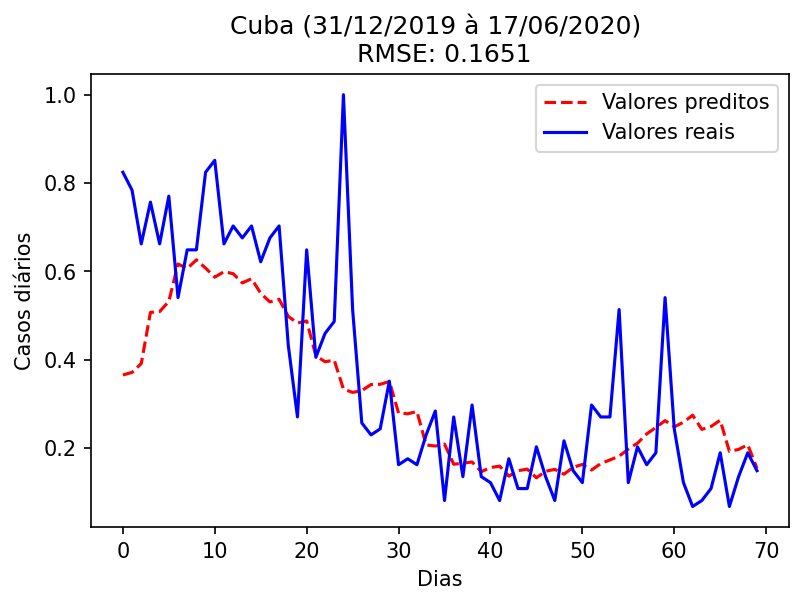

<Figure size 432x288 with 0 Axes>

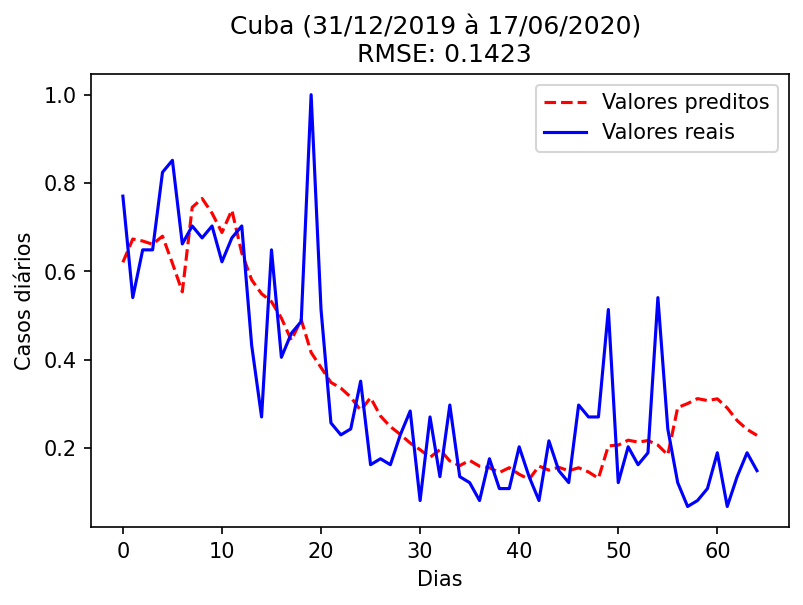

<Figure size 432x288 with 0 Axes>

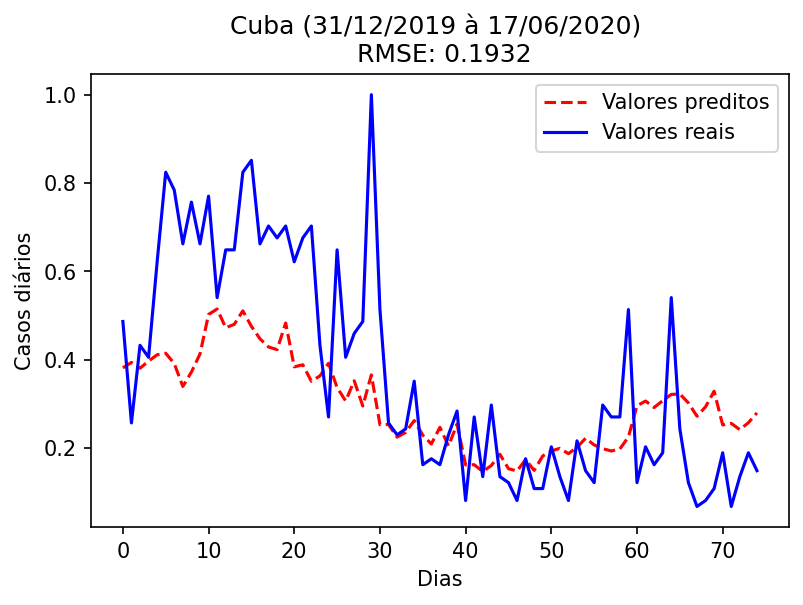

<Figure size 432x288 with 0 Axes>

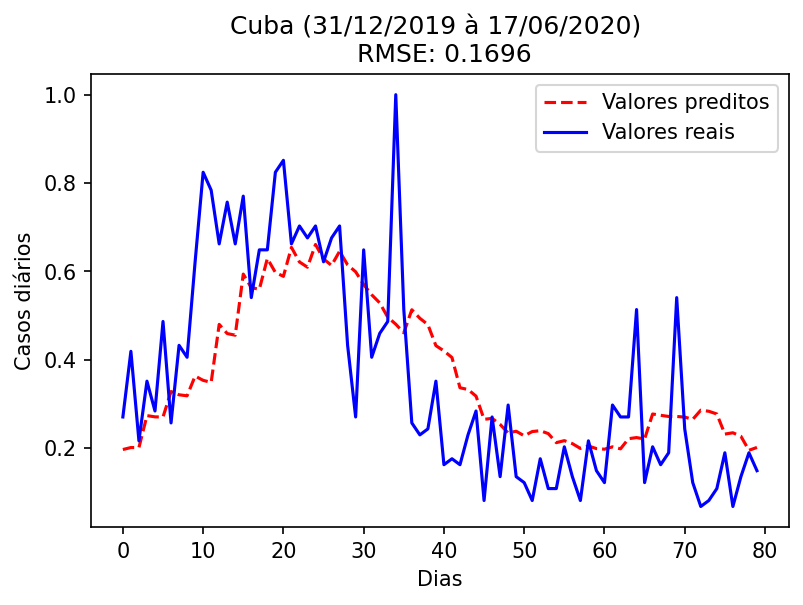

In [ ]:
cub_paramsrange = multiplas_execucoes("Cuba", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                      "Cuba (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**México**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Mexico_v0
Epoch 1/2
135/135 [==============================] - 5s 35ms/step - loss: 0.0242
Epoch 2/2
135/135 [==============================] - 4s 30ms/step - loss: 0.0106
Modelo_Mexico_v1
Epoch 1/2
126/126 [==============================] - 5s 38ms/step - loss: 0.0296
Epoch 2/2
126/126 [==============================] - 4s 34ms/step - loss: 0.0038
entrou condi
Modelo_Mexico_v2
Epoch 1/2
133/133 [==============================] - 4s 28ms/step - loss: 0.1107
Epoch 2/2
133/133 [==============================] - 3s 25ms/step - loss: 0.0112
Modelo_Mexico_v3
Epoch 1/2
145/145 [==============================] - 3s 22ms/step - loss: 0.0215
Epoch 2/2
145/145 [==============================] - 3s 19ms/step - loss: 0.0070
Modelo_Mexico_v0
Epoch 1/3
135/135 [==============================] - 5s 35ms/step - loss: 0.0649
Epoch 2/3
135/135 [==============================] - 4s 29ms/step - loss: 0.0257
Epoch 3/3
135/135 [==============================] - 4s 29ms/step - loss: 0.0057
Modelo_Mexi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Mexico_v3
Epoch 1/4
145/145 [==============================] - 3s 22ms/step - loss: 0.0241
Epoch 2/4
145/145 [==============================] - 3s 19ms/step - loss: 0.0134
Epoch 3/4
145/145 [==============================] - 3s 19ms/step - loss: 0.0055
Epoch 4/4
145/145 [==============================] - 3s 18ms/step - loss: 0.0034


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

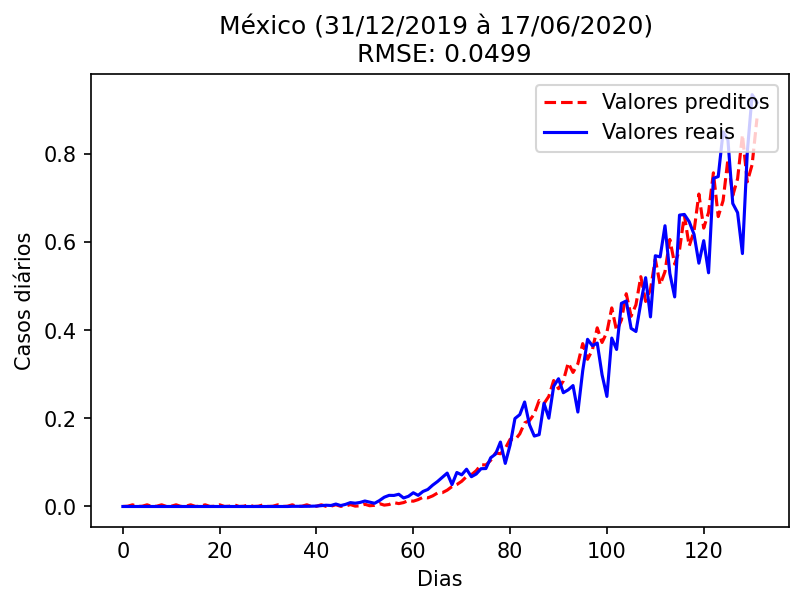

<Figure size 432x288 with 0 Axes>

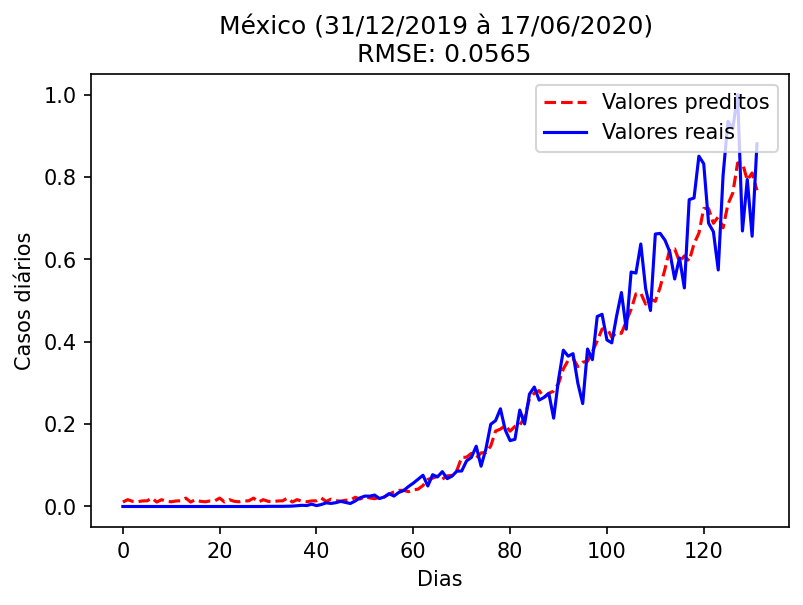

<Figure size 432x288 with 0 Axes>

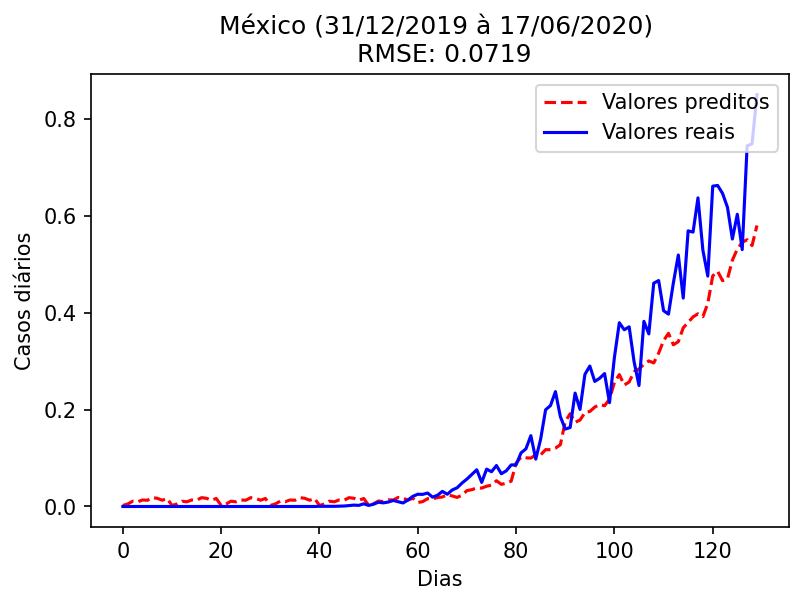

<Figure size 432x288 with 0 Axes>

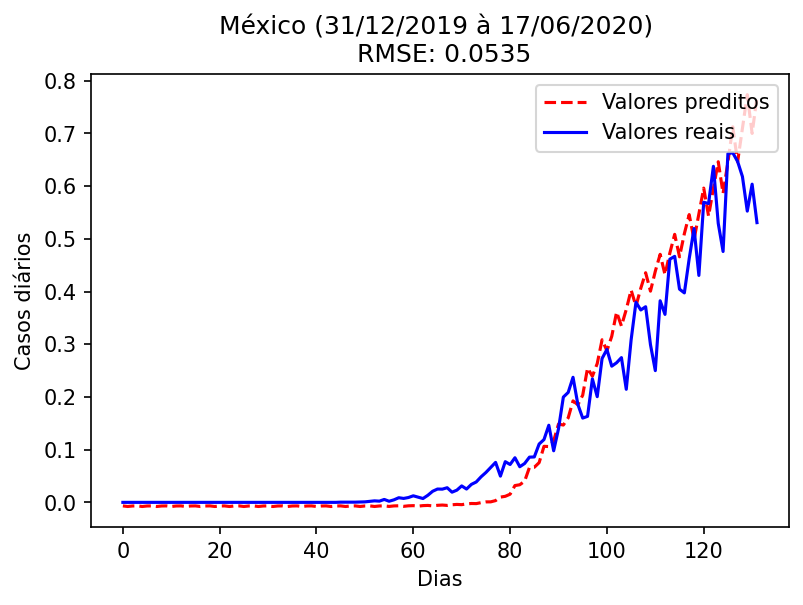

<Figure size 432x288 with 0 Axes>

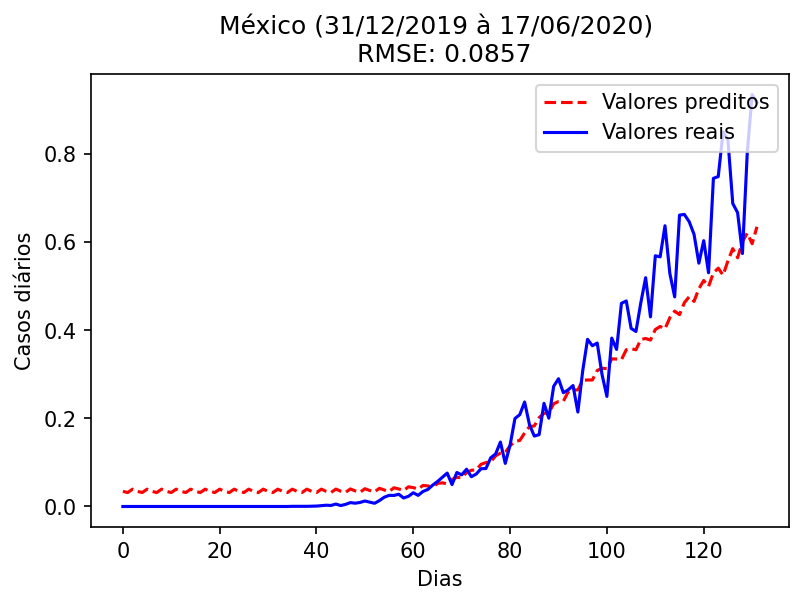

<Figure size 432x288 with 0 Axes>

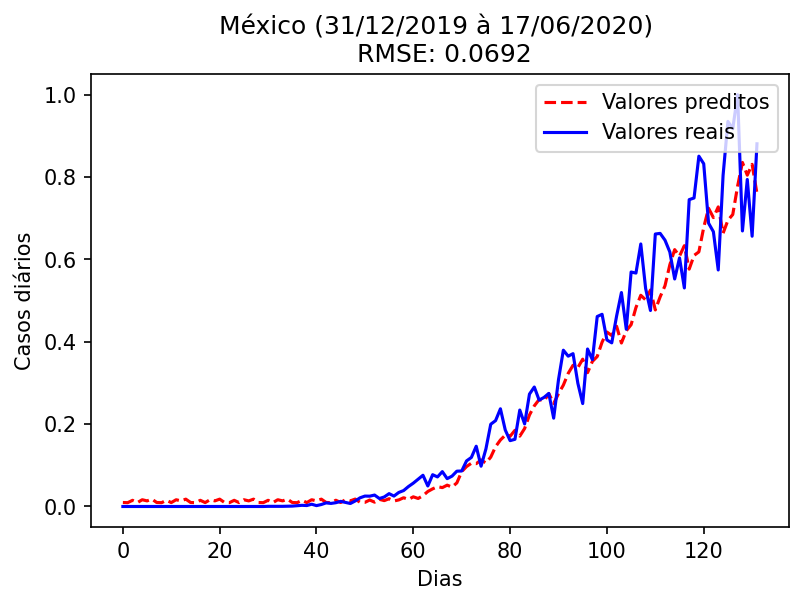

<Figure size 432x288 with 0 Axes>

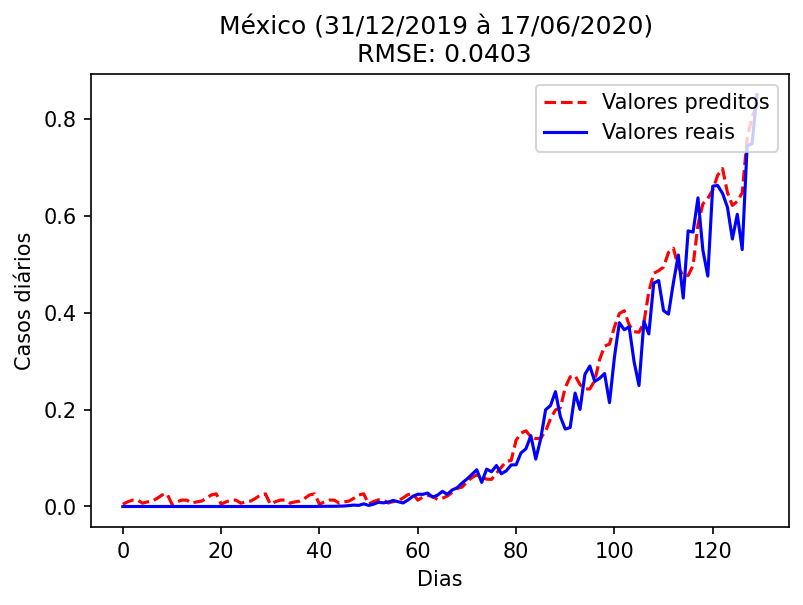

<Figure size 432x288 with 0 Axes>

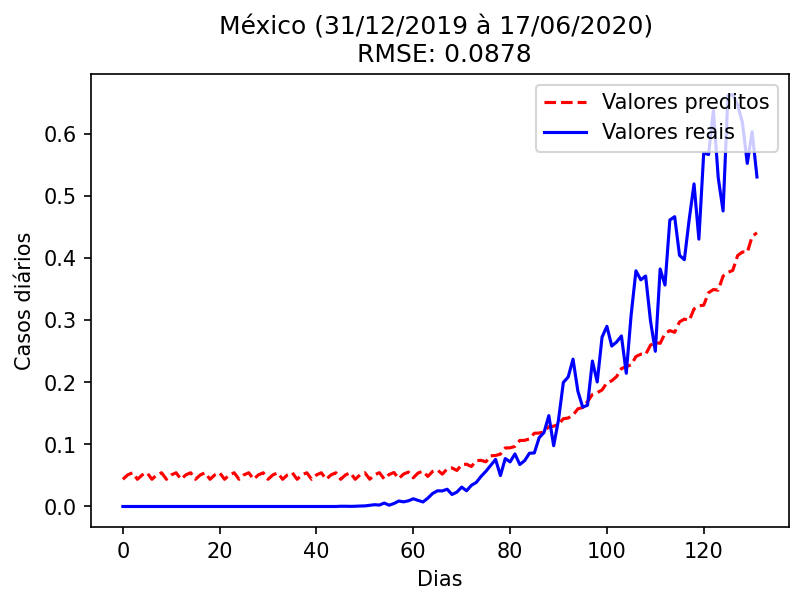

<Figure size 432x288 with 0 Axes>

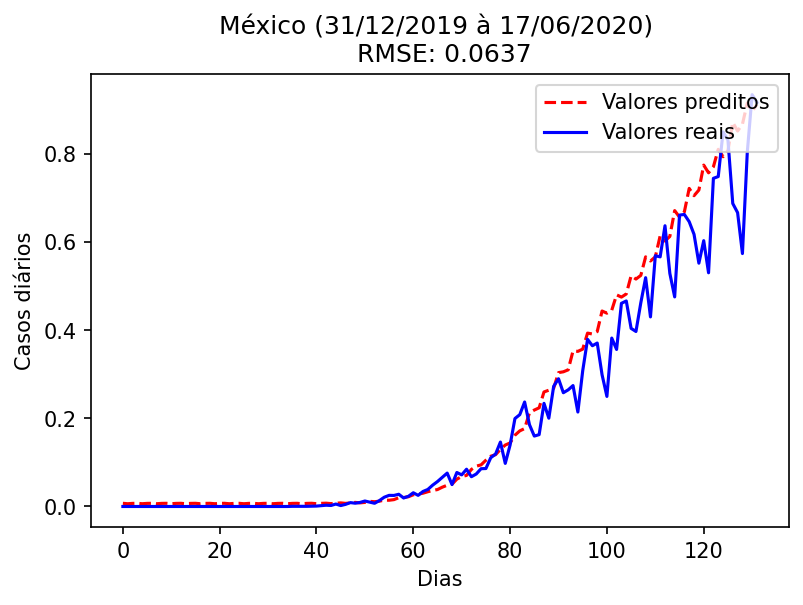

<Figure size 432x288 with 0 Axes>

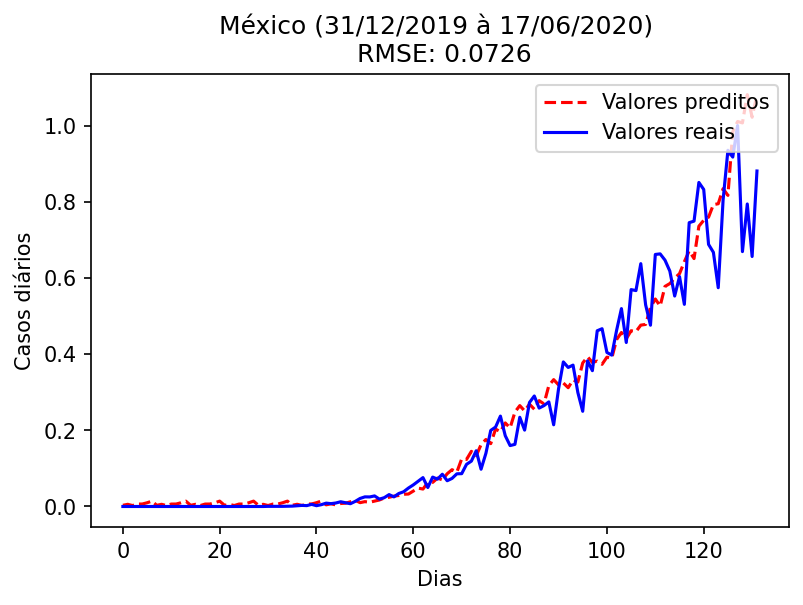

<Figure size 432x288 with 0 Axes>

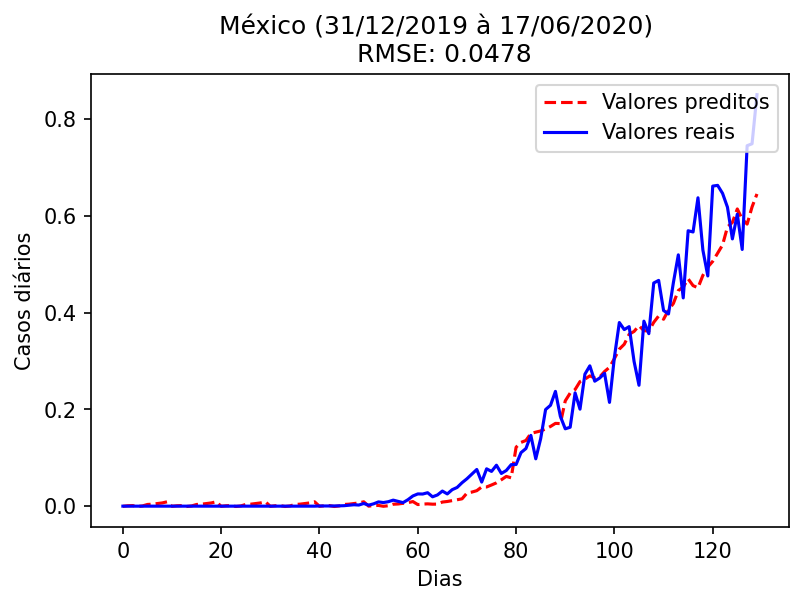

<Figure size 432x288 with 0 Axes>

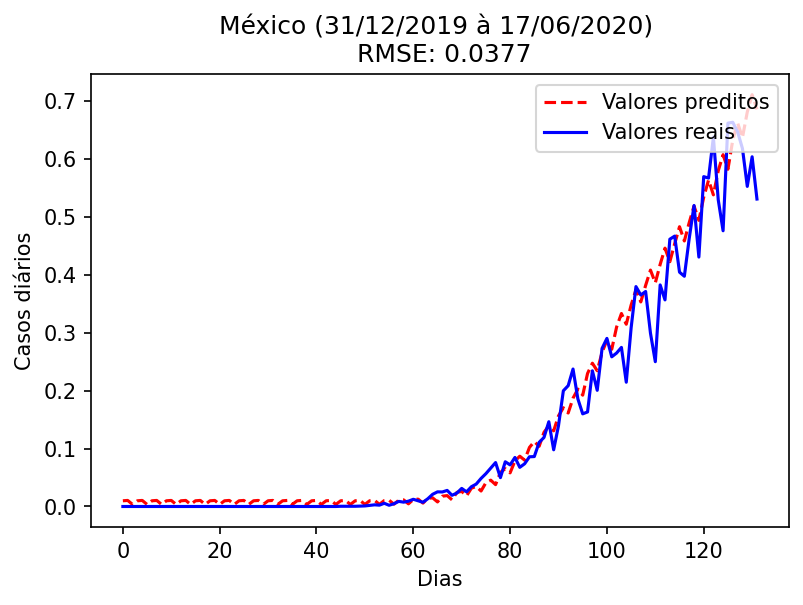

In [ ]:
mex_paramsrange = multiplas_execucoes("Mexico", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                 "México (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Rússia**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Russia_v0
Epoch 1/2
143/143 [==============================] - 5s 32ms/step - loss: 0.0955
Epoch 2/2
143/143 [==============================] - 4s 30ms/step - loss: 0.0173
Modelo_Russia_v1
Epoch 1/2
134/134 [==============================] - 5s 37ms/step - loss: 958.9824
Epoch 2/2
134/134 [==============================] - 4s 34ms/step - loss: 0.0770
Modelo_Russia_v2
Epoch 1/2
141/141 [==============================] - 4s 27ms/step - loss: 0.1244
Epoch 2/2
141/141 [==============================] - 3s 24ms/step - loss: 0.0387
Modelo_Russia_v3
Epoch 1/2
153/153 [==============================] - 3s 22ms/step - loss: 0.0355
Epoch 2/2
153/153 [==============================] - 3s 18ms/step - loss: 0.0108
Modelo_Russia_v0
Epoch 1/3
143/143 [==============================] - 5s 33ms/step - loss: 0.0542
Epoch 2/3
143/143 [==============================] - 4s 29ms/step - loss: 0.0095
Epoch 3/3
143/143 [==============================] - 4s 29ms/step - loss: 0.0062
Modelo_Russia_v1
Epoch

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Russia_v3
Epoch 1/4
153/153 [==============================] - 3s 21ms/step - loss: 0.0671
Epoch 2/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0108
Epoch 3/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0070
Epoch 4/4
153/153 [==============================] - 3s 19ms/step - loss: 0.0073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

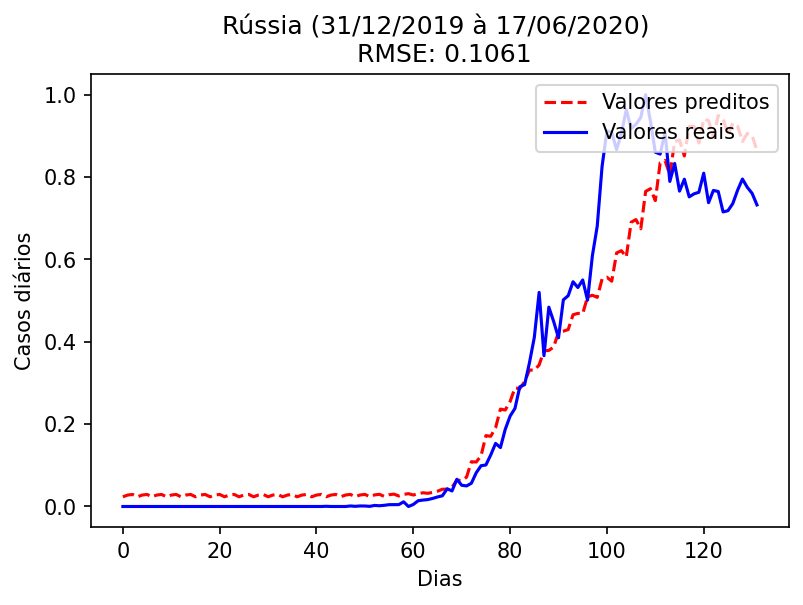

<Figure size 432x288 with 0 Axes>

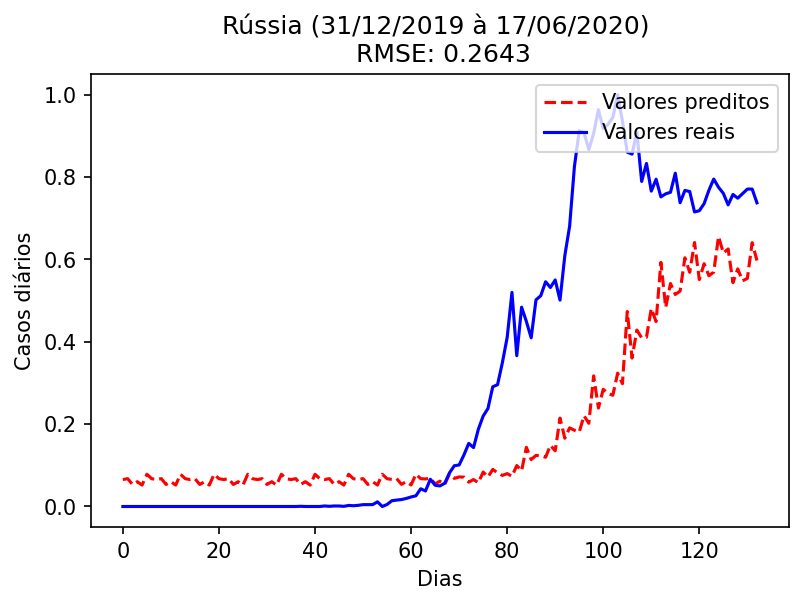

<Figure size 432x288 with 0 Axes>

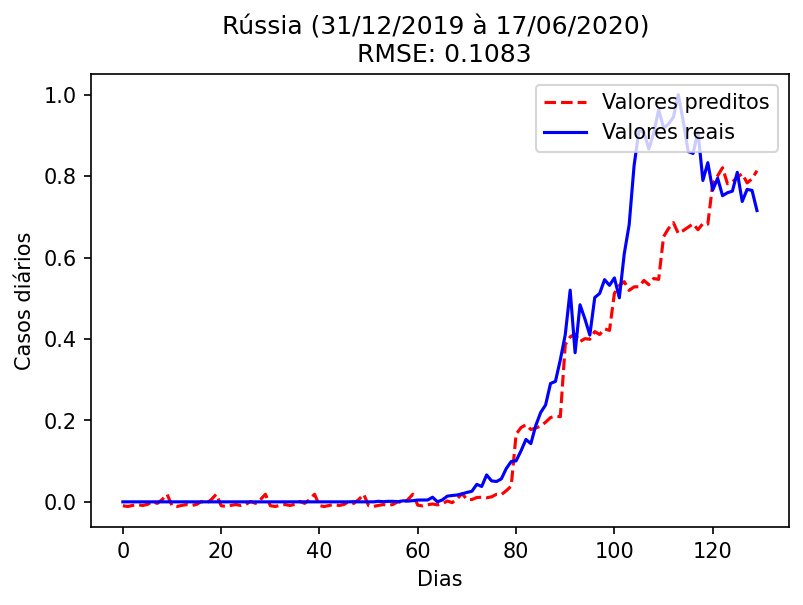

<Figure size 432x288 with 0 Axes>

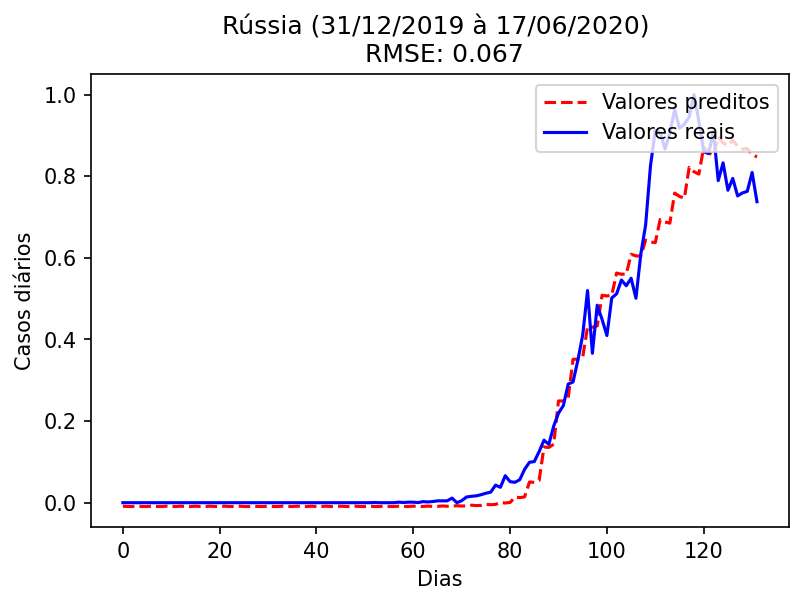

<Figure size 432x288 with 0 Axes>

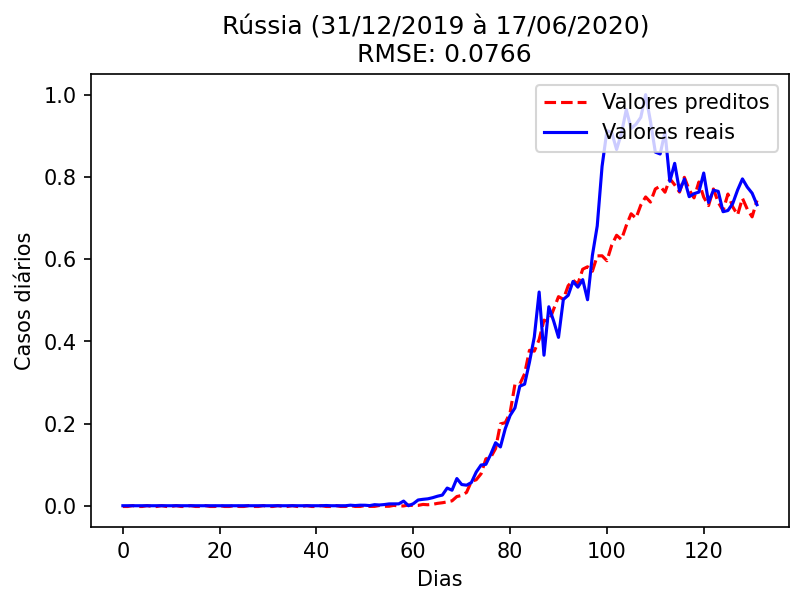

<Figure size 432x288 with 0 Axes>

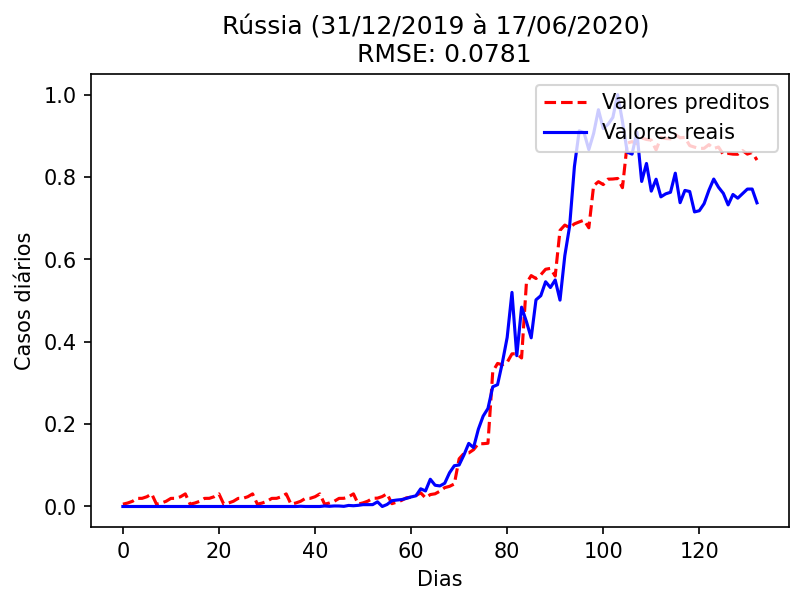

<Figure size 432x288 with 0 Axes>

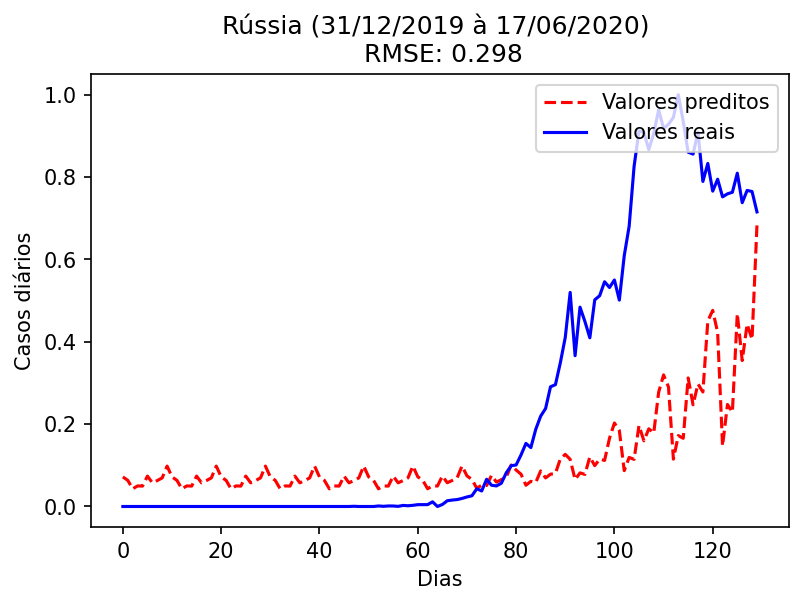

<Figure size 432x288 with 0 Axes>

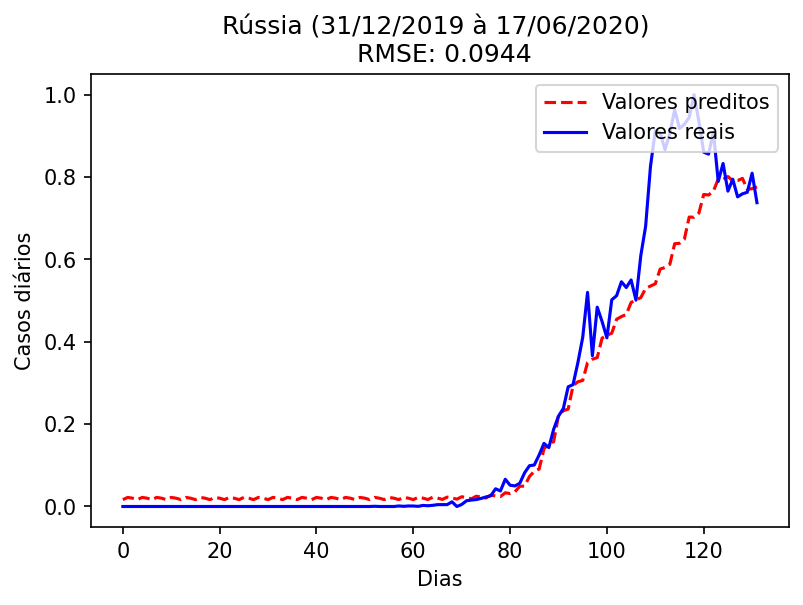

<Figure size 432x288 with 0 Axes>

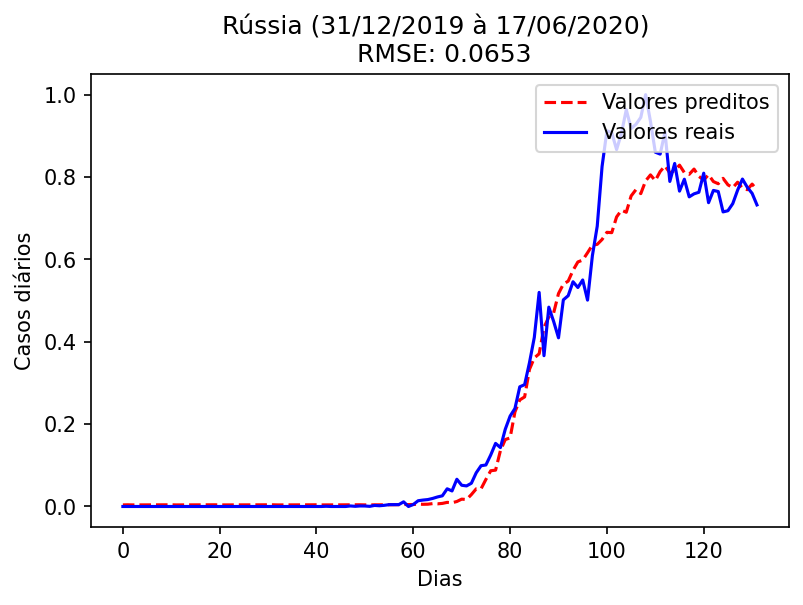

<Figure size 432x288 with 0 Axes>

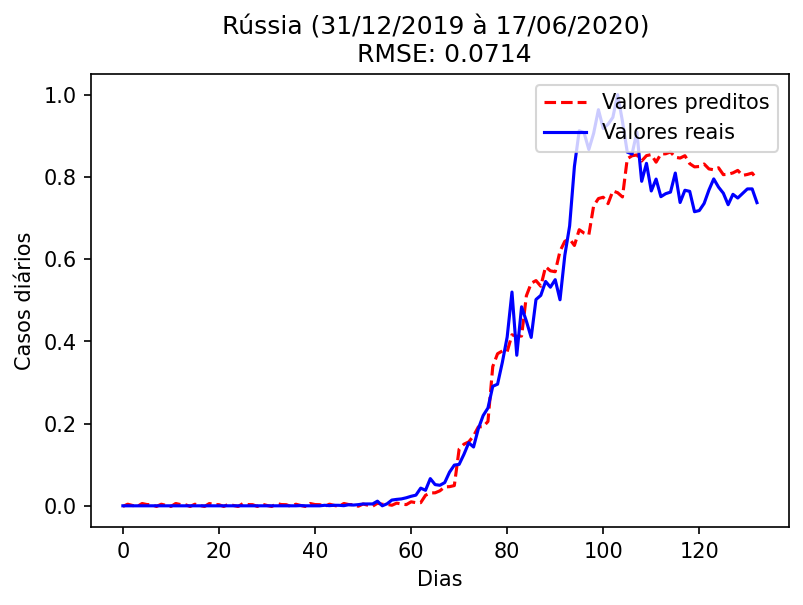

<Figure size 432x288 with 0 Axes>

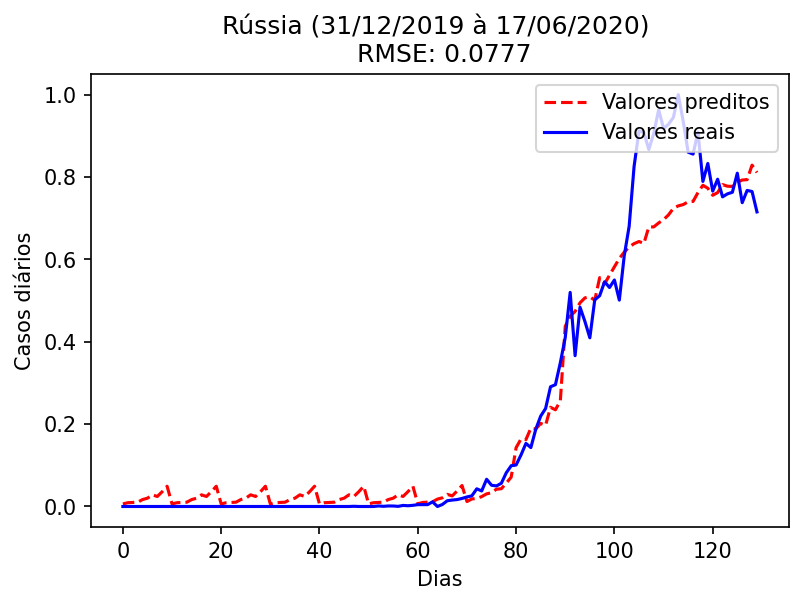

<Figure size 432x288 with 0 Axes>

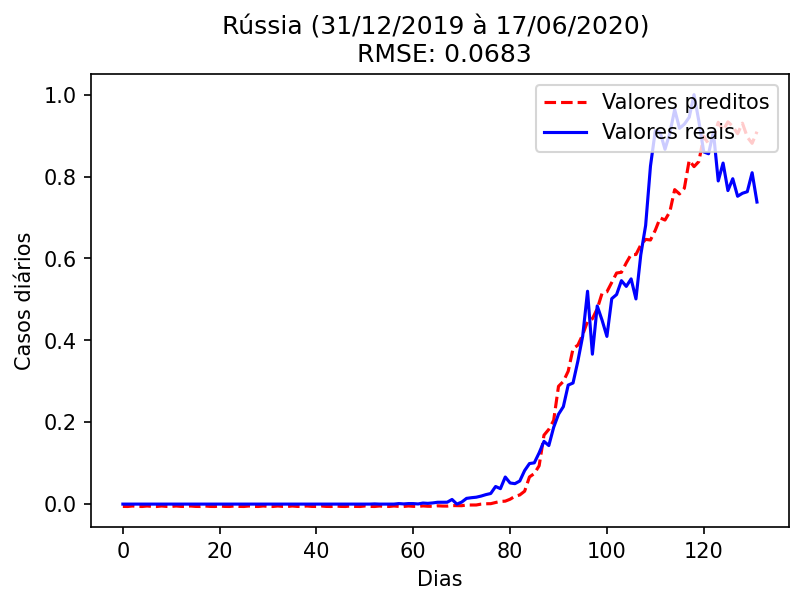

In [ ]:
rus_paramsrange = multiplas_execucoes("Russia", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                 "Rússia (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

**Brasil**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: EpochsChange: O programa está sendo executado no modo de múltiplas épocas


Modelo_Brazil_v0
Epoch 1/2
143/143 [==============================] - 4s 30ms/step - loss: 0.0421
Epoch 2/2
143/143 [==============================] - 4s 28ms/step - loss: 0.0343
Modelo_Brazil_v1
Epoch 1/2
134/134 [==============================] - 5s 38ms/step - loss: 0.0924
Epoch 2/2
134/134 [==============================] - 4s 33ms/step - loss: 0.0181
Modelo_Brazil_v2
Epoch 1/2
141/141 [==============================] - 4s 26ms/step - loss: 0.0498
Epoch 2/2
141/141 [==============================] - 3s 23ms/step - loss: 0.0132
Modelo_Brazil_v3
Epoch 1/2
153/153 [==============================] - 3s 20ms/step - loss: 0.0326
Epoch 2/2
153/153 [==============================] - 3s 19ms/step - loss: 0.0152
Modelo_Brazil_v0
Epoch 1/3
143/143 [==============================] - 4s 31ms/step - loss: 0.0347
Epoch 2/3
143/143 [==============================] - 4s 28ms/step - loss: 0.0146
Epoch 3/3
143/143 [==============================] - 4s 28ms/step - loss: 0.0087
Modelo_Brazil_v1
Epoch 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Modelo_Brazil_v3
Epoch 1/4
153/153 [==============================] - 3s 20ms/step - loss: 0.0225
Epoch 2/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0118
Epoch 3/4
153/153 [==============================] - 3s 18ms/step - loss: 0.0106
Epoch 4/4
153/153 [==============================] - 3s 17ms/step - loss: 0.0090


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

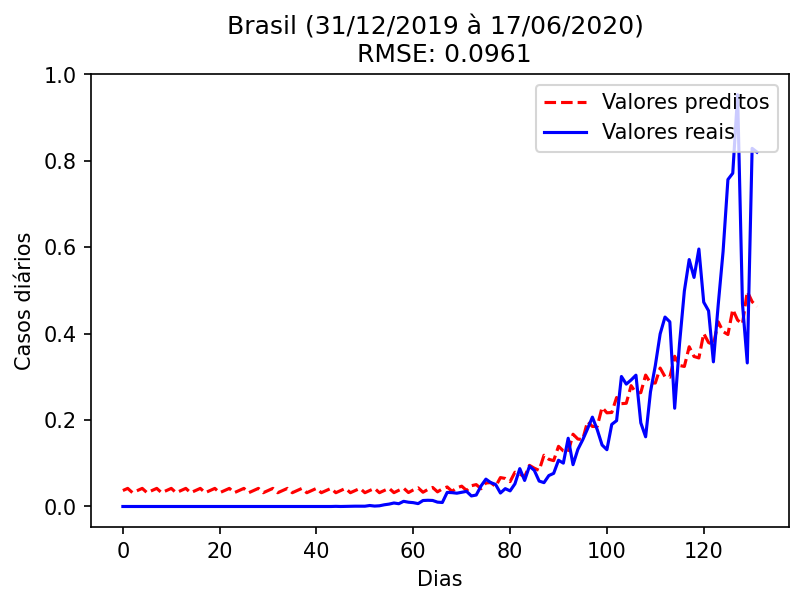

<Figure size 432x288 with 0 Axes>

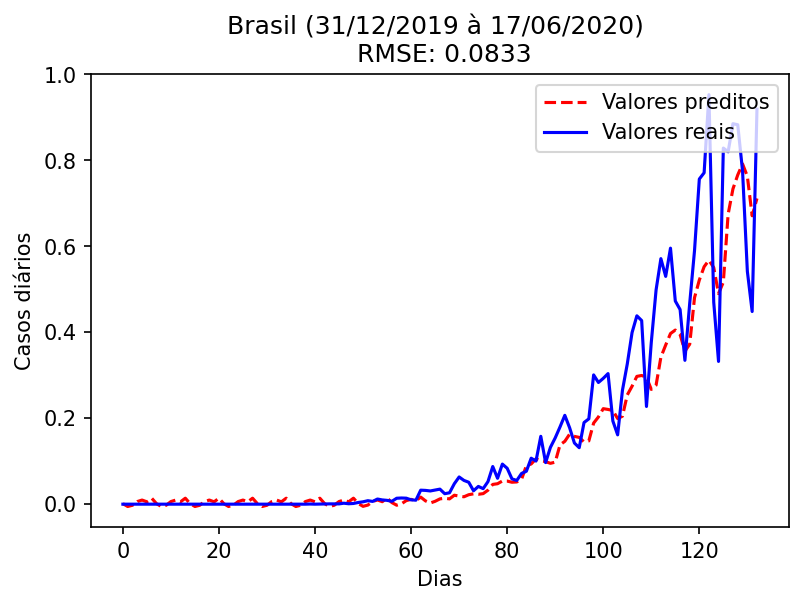

<Figure size 432x288 with 0 Axes>

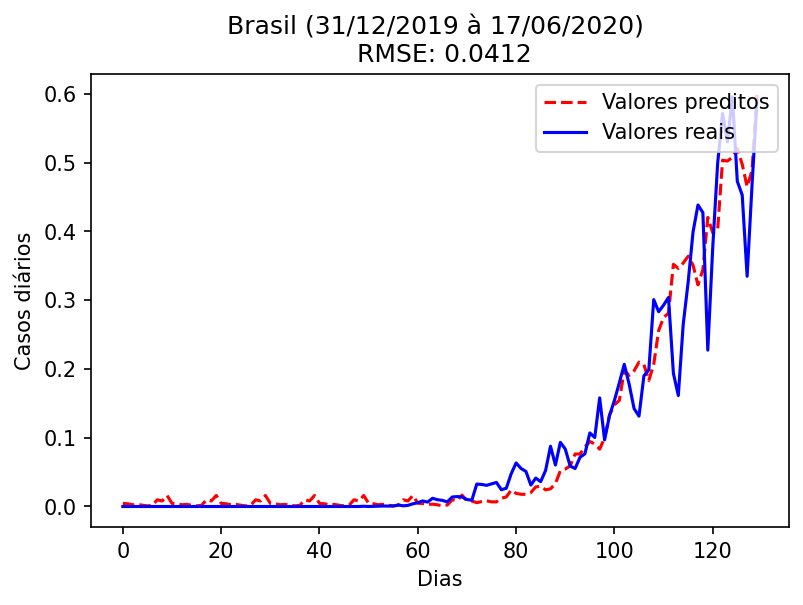

<Figure size 432x288 with 0 Axes>

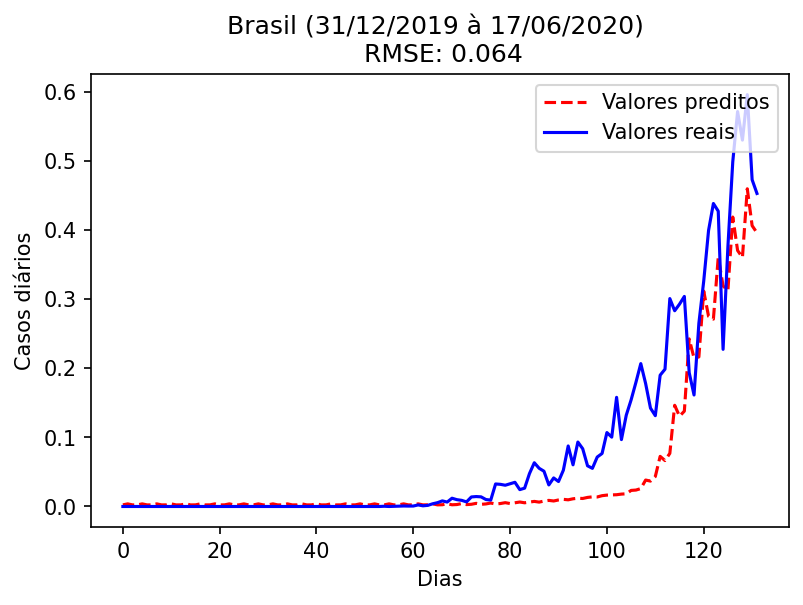

<Figure size 432x288 with 0 Axes>

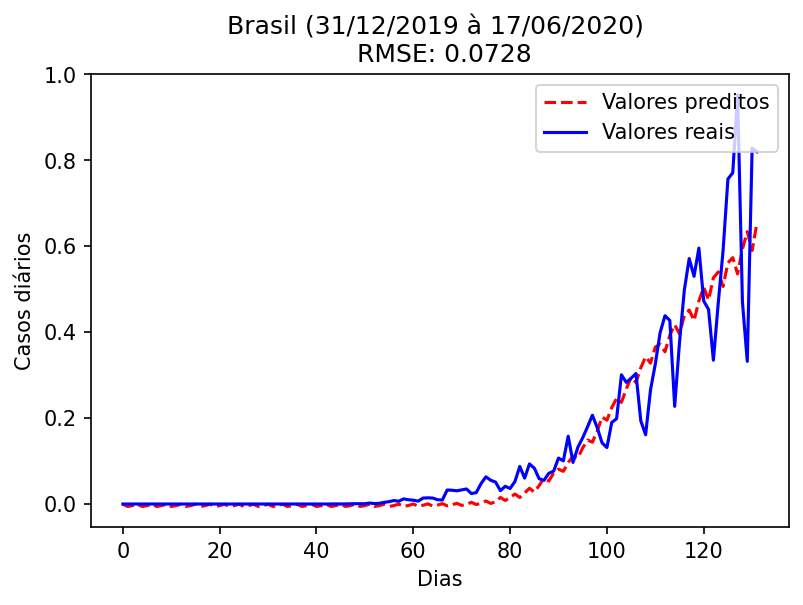

<Figure size 432x288 with 0 Axes>

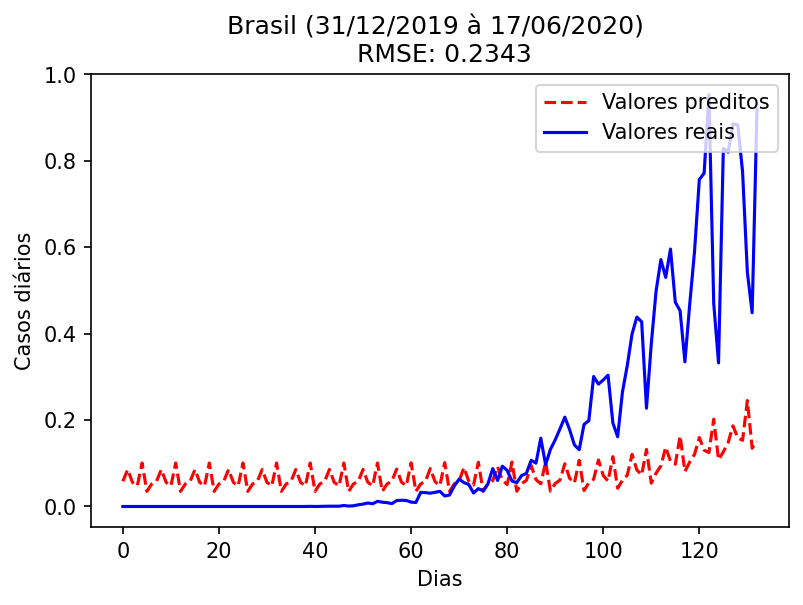

<Figure size 432x288 with 0 Axes>

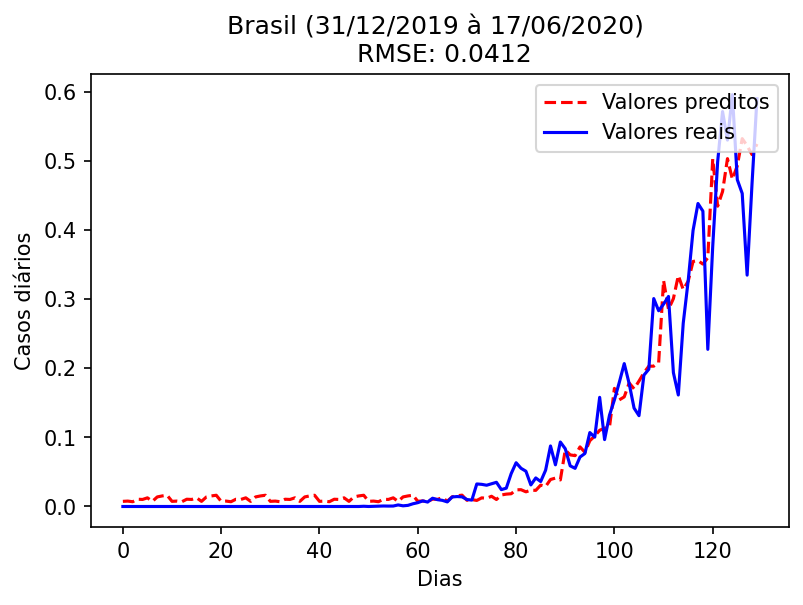

<Figure size 432x288 with 0 Axes>

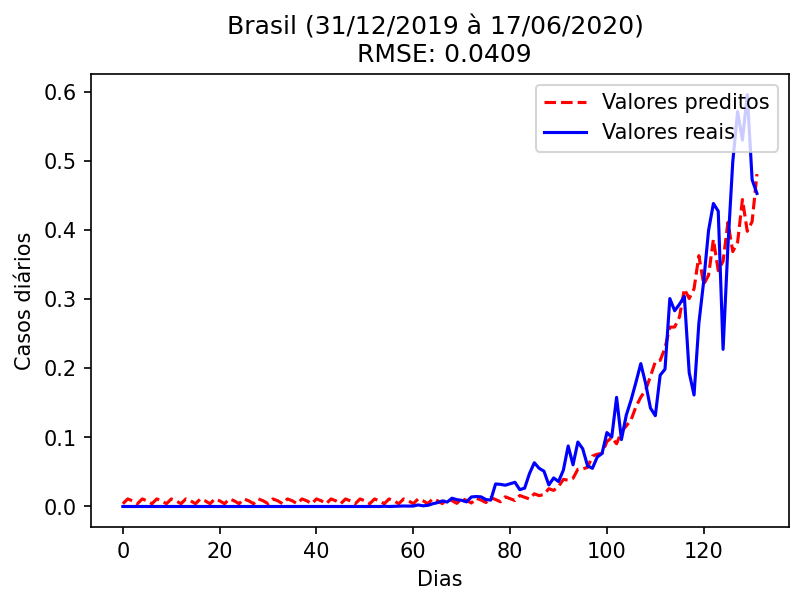

<Figure size 432x288 with 0 Axes>

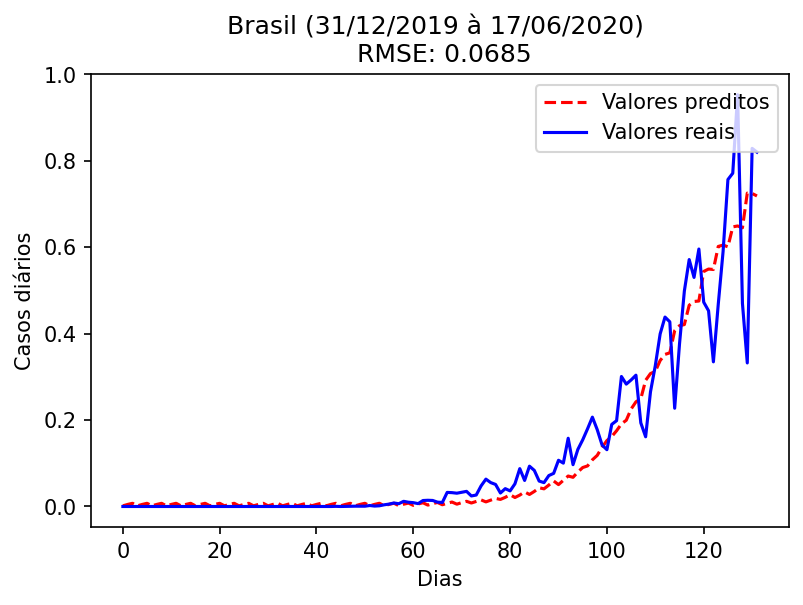

<Figure size 432x288 with 0 Axes>

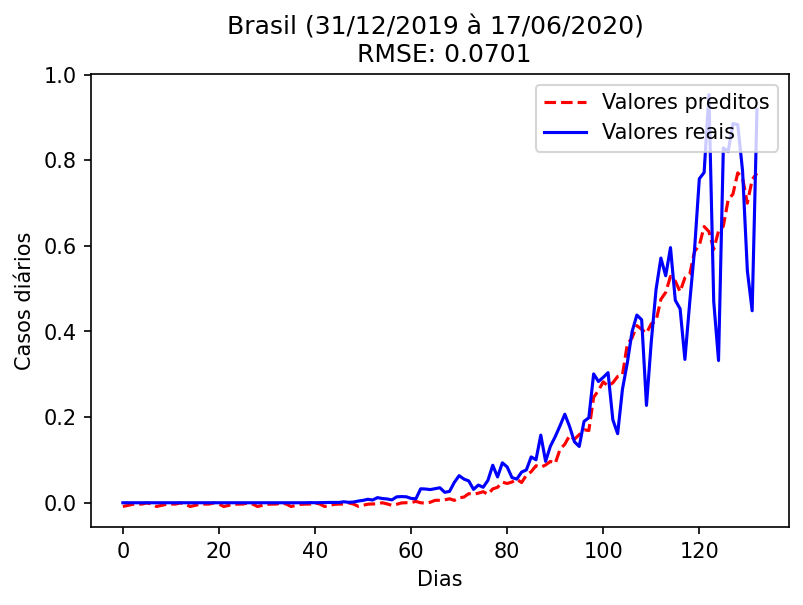

<Figure size 432x288 with 0 Axes>

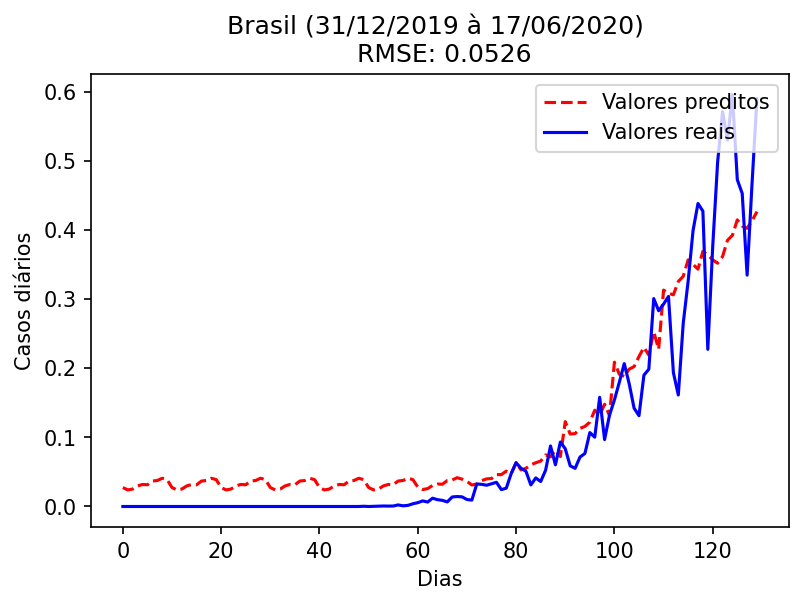

<Figure size 432x288 with 0 Axes>

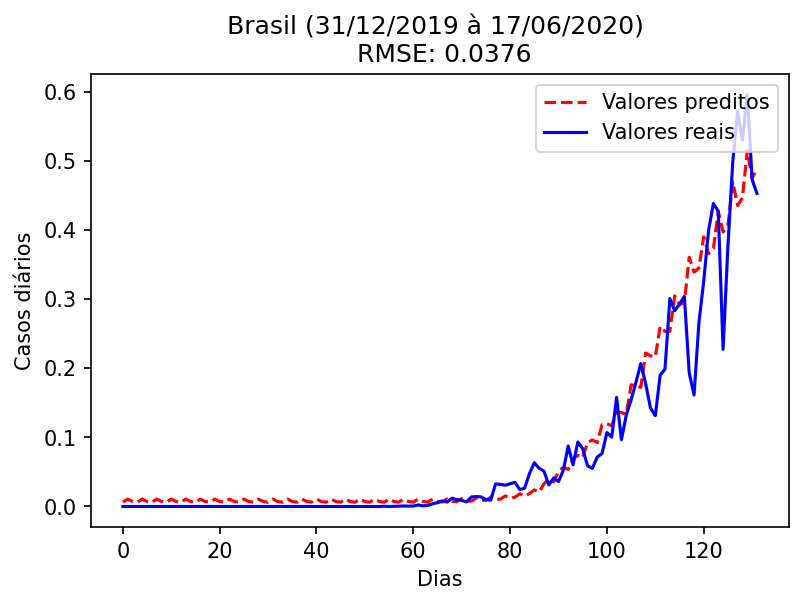

In [ ]:
bras_paramsrange = multiplas_execucoes("Brazil", [(25, 3), (30, 7), (20, 10), (15, 3)], 
                                  "Brasil (31/12/2019 à 17/06/2020) \n RMSE: {rmse}", epochs_range = (2, 5))

In [ ]:
bras_paramsrange.head()

nome_modelo versao  entradas      rmse  epoch
0  Modelo_Brazil_v0     v0   (25, 3)  0.096061      2
1  Modelo_Brazil_v1     v1   (30, 7)  0.083271      2
2  Modelo_Brazil_v2     v2  (20, 10)  0.041187      2
3  Modelo_Brazil_v3     v3   (15, 3)  0.064007      2
0  Modelo_Brazil_v0     v0   (25, 3)  0.072767      3